# install & import libraries

In [ ]:
!pip install lightgbm==3.3.5

In [ ]:
!pip install sktime

In [ ]:
#필요한 library import
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tq
from tqdm import tqdm
import sktime

from scipy.stats import spearmanr

print("tqdm version: {}".format(tq.__version__))

import warnings
warnings.filterwarnings('ignore')

tqdm version: 4.66.1


In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from time import gmtime, strftime
import gc

from sklearn.preprocessing import LabelEncoder


from lightgbm import LGBMRegressor
from sklearn.metrics import (roc_curve, auc, accuracy_score, mean_absolute_error)

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

In [ ]:
import os
SEED = 2023
np.random.seed(SEED)

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


# data load

In [ ]:
train = pd.read_csv('/gdrive/MyDrive/dacon-전력 사용량 예측 공모전/전력사용량 예측 공모전/data/processing/train_preprocessed_incsolar1.csv')
test = pd.read_csv('/gdrive/MyDrive/dacon-전력 사용량 예측 공모전/전력사용량 예측 공모전/data/processing/test_preprocessed_incsolar1.csv')

In [ ]:
train.head()

,num,date_time,power,prec,wind,hum,temp,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH,solar_flag,senstemp
0,1,2022-06-01 00:00:00,1085.28,0.0,0.9,42.0,18.6,2,6,22,1774.744615,1706.318118,446.882767,1,0.000000,1.000000,49.6576,-5.4,0,17.87
1,1,2022-06-01 01:00:00,1047.36,0.0,1.1,45.0,18.0,2,6,22,1687.347692,1622.620235,439.662704,1,0.258819,0.965926,47.7625,-11.4,0,17.54
2,1,2022-06-01 02:00:00,974.88,0.0,1.5,45.0,17.7,2,6,22,1571.483077,1506.971294,412.071906,1,0.500000,0.866025,47.2225,-17.7,0,17.26
3,1,2022-06-01 03:00:00,953.76,0.0,1.4,48.0,16.7,2,6,22,1522.153846,1437.365647,391.205981,1,0.707107,0.707107,44.7856,-25.0,0,16.55
4,1,2022-06-01 04:00:00,986.40,0.0,2.8,43.0,18.4,2,6,22,1506.793846,1447.321412,381.099697,1,0.866025,0.500000,49.0061,-30.6,0,17.76


In [ ]:
test.head()

,num,date_time,power,prec,wind,hum,temp,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH,solar_flag
0,1,2022-06-01 00:00:00,1085.28,0.0,0.9,42.0,18.6,2,6,22,1774.744615,1706.318118,446.882767,1,0.000000,1.000000,49.6576,-5.4,0
1,1,2022-06-01 01:00:00,1047.36,0.0,1.1,45.0,18.0,2,6,22,1687.347692,1622.620235,439.662704,1,0.258819,0.965926,47.7625,-11.4,0
2,1,2022-06-01 02:00:00,974.88,0.0,1.5,45.0,17.7,2,6,22,1571.483077,1506.971294,412.071906,1,0.500000,0.866025,47.2225,-17.7,0
3,1,2022-06-01 03:00:00,953.76,0.0,1.4,48.0,16.7,2,6,22,1522.153846,1437.365647,391.205981,1,0.707107,0.707107,44.7856,-25.0,0
4,1,2022-06-01 04:00:00,986.40,0.0,2.8,43.0,18.4,2,6,22,1506.793846,1447.321412,381.099697,1,0.866025,0.500000,49.0061,-30.6,0


# hyperparams tuning

## all

In [ ]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

## cv fold

time series data의 특성 무시할 가능성 있음

In [ ]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import make_scorer
smape = make_scorer(SMAPE, greater_is_better = False)

df = pd.DataFrame(columns = ['learning_rate','n_estimators','num_leaves', 'boosting_type','colsample_bytree', 'subsample','max_depth','verbosity','force_col_wise'])
#멈춘 부분 부터 ~
#df = pd.read_csv('/gdrive/MyDrive/dacon/LGBM/hyperparams_lgbm.csv')
preds = np.array([])

features = ['prec', 'wind', 'hum', 'temp', 'day', 'week', 'day_hour_mean', 'day_hour_std', 'holiday', 'sin_time', 'cos_time', 'THI', 'CDH', 'solar_flag']

grid = {
    #"device": ["gpu"],
    #'learning_rate': [0.01, 0.05, 0.1],
    #'n_estimators' : [100, 500],
    'n_estimators': [100],
    'num_leaves': [6, 8, 12, 16],  # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type': ['gbdt'], #sometimes dart gives better accuracy
    #'max_bin': [255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'subsample': [0.7, 0.8,0.9, 1.0],
    'max_depth': [3,4,5,6,7,8],#3,4
    'verbosity' : [-1],
    'force_col_wise': [True],

    #'min_child_weight' : np.arange(1, 8, 1), #overitting 처리
     } # fix the n_estimators & eta(learning rate)


In [ ]:
df.to_csv('/gdrive/MyDrive/dacon/LGBM/hyperparams_lgbm_mae.csv', index = False) # save the tuned parameters
#df =pd.read_csv('/gdrive/MyDrive/dacon/LGBM/hyperparams_lgbm_mae.csv')

In [ ]:
# 건물 번호별로 GridSearch로 parameter 생성
for i in tqdm(np.arange(41, 101)):
    y = train.loc[train.num == i, 'power']
    x = train.loc[train.num == i, features]
    # 마지막 일주일 발전량을 validset으로 24시간*7일 = 168
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)

    fit_params = {"early_stopping_rounds": 300,
                  'eval_metric':'mae',
                  'eval_set':[[x_test, y_test]],
                  'verbose': -1}

    grid = {
    #"device": ["gpu"],
    #'learning_rate': [0.01, 0.05, 0.1],
    'learning_rate': [lrs[i-1]],
    #'n_estimators' : [100, 500],
    'n_estimators': [100],
    'num_leaves': [6, 8, 12, 16],  # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type': ['gbdt'], #sometimes dart gives better accuracy
    #'max_bin': [255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'subsample': [0.7, 0.8,0.9, 1.0],
    'max_depth': [3,4,5,6,7,8],#3,4
    'verbosity' : [-1],
    'force_col_wise': [True],

    #'min_child_weight' : np.arange(1, 8, 1), #overitting 처리
     } # fix the n_estimators & eta(learning rate)

    #lr = lrs[i -1]
    #print(lr)
    # pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
    gcv = GridSearchCV(estimator = LGBMRegressor(seed = 0),
                       param_grid = grid, scoring = smape, cv = 5, refit = True, verbose = False)


    gcv.fit(x_train, y_train, **fit_params)
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)
    pred = best.predict(x_test)
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y_test, pred)))
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)

    #gpu - /content/drive/MyDrive/dacon/LGBM/hyperparams_lgbm.csv
    #cpu - /gdrive/MyDrive/dacon/LGBM/hyperparams_lgbm.csv

    df.to_csv('/gdrive/MyDrive/dacon/LGBM/hyperparams_lgbm_mae.csv', index = False) # save the tuned parameters

 10%|█         | 1/10 [02:14<20:13, 134.84s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 12, 'subsample': 0.7, 'verbosity': -1}
building31|| SMAPE : 2.637155495884918


 20%|██        | 2/10 [04:24<17:35, 131.95s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 8, 'subsample': 0.7, 'verbosity': -1}
building32|| SMAPE : 0.21664435752410924


 30%|███       | 3/10 [06:45<15:50, 135.81s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 8, 'subsample': 0.7, 'verbosity': -1}
building33|| SMAPE : 0.18594144963027495


 40%|████      | 4/10 [09:04<13:42, 137.13s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 8, 'subsample': 0.7, 'verbosity': -1}
building34|| SMAPE : 0.3312560119210549


 50%|█████     | 5/10 [11:30<11:42, 140.50s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 8, 'subsample': 0.7, 'verbosity': -1}
building35|| SMAPE : 0.21849526316849852


 60%|██████    | 6/10 [13:58<09:32, 143.10s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'force_col_wise': True, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 8, 'subsample': 0.7, 'verbosity': -1}
building36|| SMAPE : 0.24184941661571335


 70%|███████   | 7/10 [16:25<07:12, 144.18s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 16, 'subsample': 0.7, 'verbosity': -1}
building37|| SMAPE : 1.88593479437245


 80%|████████  | 8/10 [18:40<04:42, 141.41s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 16, 'subsample': 0.7, 'verbosity': -1}
building38|| SMAPE : 2.9227624192845303


 90%|█████████ | 9/10 [21:02<02:21, 141.41s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 16, 'subsample': 0.7, 'verbosity': -1}
building39|| SMAPE : 3.076341696101904


100%|██████████| 10/10 [23:08<00:00, 138.81s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 6, 'subsample': 0.7, 'verbosity': -1}
building40|| SMAPE : 5.004390850228787


## cv pds

마지막 일주일을 validation set으로 사용

In [ ]:
n = 8
n1 = int(2 ** n * 0.2)
n2 = int(2 ** n * 0.6)
np.append(np.linspace(n1, n2, num = 5, dtype = int),31)

array([ 51,  76, 102, 127, 153,  31])

In [ ]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import make_scorer
smape = make_scorer(SMAPE, greater_is_better = False)

df = pd.DataFrame(columns = ['learning_rate','n_estimators','colsample_bytree', 'subsample','max_depth'])
#멈춘 부분 부터 ~
#df = pd.read_csv('/gdrive/MyDrive/dacon/LGBM/hyperparams_lgbm.csv')
preds = np.array([])

features = ['prec', 'wind', 'hum', 'temp', 'day',
       'week', 'day_hour_mean', 'day_hour_std', 'holiday', 'sin_time',
       'cos_time', 'THI', 'CDH', 'solar_flag', 'senstemp', 'month']

grid = {
    #"device": ["gpu"],
    'learning_rate': [0.07],
    #'n_estimators' : [100, 500],
    'n_estimators': [100],
    #'num_leaves': [6, 8, 12, 16],  # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type': ['gbdt'], #sometimes dart gives better accuracy
    #'max_bin': [255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'colsample_bytree': [0.7, 0.8, 0.9],
    #'subsample': [0.3, 0.5, 0.7,],
    #'subsample': [1.0],
    #'min_child_samples': [50],
    'max_depth': [3,4,5,6,7,8],#3,4
    'verbosity' : [-1],
    'force_col_wise': [True],

    #'min_child_weight' : np.arange(1, 8, 1), #overfitting 처리
     } # fix the n_estimators

addtr = 5

In [ ]:
# 건물 번호별로 GridSearch로 parameter 생성
df = pd.DataFrame(columns = ['learning_rate','n_estimators', 'colsample_bytree','max_depth'])
sm_list = []
preds = np.array([])
for i in tqdm(np.arange(1, 101)):
    y = train.loc[train.num == i, 'power']
    x = train.loc[train.num == i, features]
    # 마지막 일주일 발전량을 validset으로 24시간*7일 = 168
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)

    pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
    gcv = GridSearchCV(estimator = LGBMRegressor(seed = 0, metric = 'mae'),
                       param_grid = grid, scoring = smape, cv = pds, refit = True, verbose = False)


    gcv.fit(x, y, eval_metric = 'mae')

    best = gcv.best_estimator_
    pred = best.predict(x_test)

    # if SMAPE(y_test, pred) >= addtr:
    #   grid['learning_rate'] = [0.02]
    #   grid['n_estimators'] = [500]
    #   gcv = GridSearchCV(estimator = LGBMRegressor(seed = 0, metric = 'huber'),
    #                    param_grid = grid, scoring = smape, cv = pds, refit = True, verbose = False)

    #   gcv.fit(x, y, eval_metric = 'huber')

    params = gcv.best_params_
    print(params)
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y_test, pred)))
    sm_list = np.append(sm_list, SMAPE(y_test, pred) )
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)
    df.to_csv('/gdrive/MyDrive/dacon/LGBM/params_0824_stonly.csv', index = False)

  1%|          | 1/100 [00:06<10:59,  6.66s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building1|| SMAPE : 1.4042582631444736


  2%|▏         | 2/100 [00:08<05:47,  3.54s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building2|| SMAPE : 2.0435438750473125


  3%|▎         | 3/100 [00:09<04:06,  2.54s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building3|| SMAPE : 2.47197962636467


  4%|▍         | 4/100 [00:10<03:24,  2.13s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building4|| SMAPE : 1.1527555323813246


  5%|▌         | 5/100 [00:12<02:54,  1.84s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building5|| SMAPE : 1.5382461421479894


  6%|▌         | 6/100 [00:13<02:41,  1.72s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building6|| SMAPE : 1.1549192478726902


  7%|▋         | 7/100 [00:15<02:30,  1.62s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building7|| SMAPE : 1.8898905666424708


  8%|▊         | 8/100 [00:20<04:12,  2.75s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building8|| SMAPE : 1.7104026959664536


  9%|▉         | 9/100 [00:21<03:31,  2.32s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building9|| SMAPE : 1.0577085756513298


 10%|█         | 10/100 [00:23<03:02,  2.03s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building10|| SMAPE : 1.9246910898075558


 11%|█         | 11/100 [00:24<02:43,  1.84s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building11|| SMAPE : 1.17082152490899


 12%|█▏        | 12/100 [00:25<02:30,  1.72s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building12|| SMAPE : 0.9414305264040672


 13%|█▎        | 13/100 [00:27<02:19,  1.60s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building13|| SMAPE : 1.7470978451315862


 14%|█▍        | 14/100 [00:28<02:09,  1.51s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building14|| SMAPE : 4.488609178668044


 15%|█▌        | 15/100 [00:30<02:08,  1.51s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building15|| SMAPE : 0.6950653139254483


 16%|█▌        | 16/100 [00:35<03:39,  2.61s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building16|| SMAPE : 1.648106145024366


 17%|█▋        | 17/100 [00:36<03:06,  2.24s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building17|| SMAPE : 1.8650644735620145


 18%|█▊        | 18/100 [00:37<02:41,  1.97s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building18|| SMAPE : 2.021989284217284


 19%|█▉        | 19/100 [00:39<02:26,  1.81s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building19|| SMAPE : 1.1359268824305893


 20%|██        | 20/100 [00:40<02:12,  1.66s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building20|| SMAPE : 1.0265290731715082


 21%|██        | 21/100 [00:41<02:02,  1.55s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building21|| SMAPE : 2.54653400483217


 22%|██▏       | 22/100 [00:43<01:57,  1.51s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building22|| SMAPE : 0.9301172989048935


 23%|██▎       | 23/100 [00:48<03:20,  2.60s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building23|| SMAPE : 0.5433132050363653


 24%|██▍       | 24/100 [00:49<02:51,  2.26s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building24|| SMAPE : 0.4947415962652876


 25%|██▌       | 25/100 [00:51<02:30,  2.00s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building25|| SMAPE : 0.6772462469071273


 26%|██▌       | 26/100 [00:52<02:14,  1.82s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building26|| SMAPE : 0.5963967459072249


 27%|██▋       | 27/100 [00:54<02:04,  1.70s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building27|| SMAPE : 0.5756063292343334


 28%|██▊       | 28/100 [00:55<01:55,  1.60s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building28|| SMAPE : 1.1668357831133727


 29%|██▉       | 29/100 [00:56<01:49,  1.54s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building29|| SMAPE : 0.8935368250675393


 30%|███       | 30/100 [00:58<01:42,  1.47s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building30|| SMAPE : 2.6648009084438335


 31%|███       | 31/100 [01:03<02:59,  2.60s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building31|| SMAPE : 0.92035300787909


 32%|███▏      | 32/100 [01:04<02:33,  2.26s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building32|| SMAPE : 0.09190642225281898


 33%|███▎      | 33/100 [01:06<02:15,  2.02s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building33|| SMAPE : 0.07638369732111248


 34%|███▍      | 34/100 [01:07<02:02,  1.85s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building34|| SMAPE : 0.1715705299400207


 35%|███▌      | 35/100 [01:09<01:51,  1.72s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building35|| SMAPE : 0.15859918058170117


 36%|███▌      | 36/100 [01:10<01:43,  1.62s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building36|| SMAPE : 0.1175133018077892


 37%|███▋      | 37/100 [01:16<03:06,  2.96s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building37|| SMAPE : 1.4916131334712632


 38%|███▊      | 38/100 [01:18<02:34,  2.49s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building38|| SMAPE : 1.6461401677853391


 39%|███▉      | 39/100 [01:22<02:58,  2.93s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building39|| SMAPE : 1.5660118571480217


 40%|████      | 40/100 [01:23<02:27,  2.46s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building40|| SMAPE : 2.4998401909988295


 41%|████      | 41/100 [01:24<02:06,  2.15s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building41|| SMAPE : 1.5835008617334587


 42%|████▏     | 42/100 [01:27<02:04,  2.15s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building42|| SMAPE : 2.9538852455119256


 43%|████▎     | 43/100 [01:31<02:41,  2.83s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building43|| SMAPE : 2.187022144389433


 44%|████▍     | 44/100 [01:32<02:15,  2.42s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building44|| SMAPE : 0.9877045365008715


 45%|████▌     | 45/100 [01:34<01:57,  2.14s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building45|| SMAPE : 0.5652073597814204


 46%|████▌     | 46/100 [01:35<01:44,  1.93s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building46|| SMAPE : 1.5275659513870614


 47%|████▋     | 47/100 [01:37<01:34,  1.78s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building47|| SMAPE : 0.9585107538997704


 48%|████▊     | 48/100 [01:38<01:28,  1.69s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building48|| SMAPE : 0.4683068950293048


 49%|████▉     | 49/100 [01:40<01:22,  1.62s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building49|| SMAPE : 0.5802600561520056


 50%|█████     | 50/100 [01:45<02:15,  2.70s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building50|| SMAPE : 0.6712172233179522


 51%|█████     | 51/100 [01:46<01:53,  2.31s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building51|| SMAPE : 0.9401005309765096


 52%|█████▏    | 52/100 [01:48<01:38,  2.04s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building52|| SMAPE : 0.8657176023357036


 53%|█████▎    | 53/100 [01:49<01:26,  1.83s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building53|| SMAPE : 2.6611313586284044


 54%|█████▍    | 54/100 [01:51<01:18,  1.71s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building54|| SMAPE : 3.1585081585804966


 55%|█████▌    | 55/100 [01:52<01:12,  1.62s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building55|| SMAPE : 0.351059082504451


 56%|█████▌    | 56/100 [01:53<01:08,  1.56s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building56|| SMAPE : 0.19538351160055456


 57%|█████▋    | 57/100 [01:59<01:54,  2.67s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building57|| SMAPE : 1.6152359494656803


 58%|█████▊    | 58/100 [02:00<01:35,  2.28s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building58|| SMAPE : 0.14952234738728684


 59%|█████▉    | 59/100 [02:01<01:22,  2.01s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building59|| SMAPE : 1.3290600076505172


 60%|██████    | 60/100 [02:03<01:12,  1.82s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building60|| SMAPE : 1.4755375333909815


 61%|██████    | 61/100 [02:04<01:06,  1.70s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building61|| SMAPE : 1.495891729632994


 62%|██████▏   | 62/100 [02:06<01:01,  1.61s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building62|| SMAPE : 1.5247349902585674


 63%|██████▎   | 63/100 [02:07<00:57,  1.56s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building63|| SMAPE : 1.3660552756216808


 64%|██████▍   | 64/100 [02:12<01:36,  2.67s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building64|| SMAPE : 1.1095010848881157


 65%|██████▌   | 65/100 [02:14<01:20,  2.29s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building65|| SMAPE : 2.030130706575305


 66%|██████▌   | 66/100 [02:15<01:09,  2.04s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building66|| SMAPE : 0.9862376787517063


 67%|██████▋   | 67/100 [02:17<01:01,  1.86s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building67|| SMAPE : 0.8951561663144422


 68%|██████▊   | 68/100 [02:18<00:55,  1.72s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building68|| SMAPE : 1.1477859392157257


 69%|██████▉   | 69/100 [02:19<00:50,  1.63s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building69|| SMAPE : 0.5800088922236132


 70%|███████   | 70/100 [02:21<00:47,  1.57s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building70|| SMAPE : 0.5689480254484218


 71%|███████   | 71/100 [02:23<00:53,  1.86s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building71|| SMAPE : 1.2560578818801265


 72%|███████▏  | 72/100 [02:27<01:09,  2.48s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building72|| SMAPE : 1.2025963745096302


 73%|███████▎  | 73/100 [02:29<00:58,  2.15s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building73|| SMAPE : 1.107534078838824


 74%|███████▍  | 74/100 [02:30<00:49,  1.91s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building74|| SMAPE : 1.8677493924576423


 75%|███████▌  | 75/100 [02:31<00:43,  1.76s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building75|| SMAPE : 0.7536626449447767


 76%|███████▌  | 76/100 [02:33<00:39,  1.66s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building76|| SMAPE : 0.9005140864267044


 77%|███████▋  | 77/100 [02:34<00:36,  1.59s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building77|| SMAPE : 0.9425981951477431


 78%|███████▊  | 78/100 [02:36<00:33,  1.54s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building78|| SMAPE : 0.710452725931492


 79%|███████▉  | 79/100 [02:41<00:55,  2.66s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building79|| SMAPE : 0.7231060115548487


 80%|████████  | 80/100 [02:42<00:46,  2.30s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building80|| SMAPE : 0.8237018562623429


 81%|████████  | 81/100 [02:44<00:38,  2.02s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building81|| SMAPE : 1.3591589167448224


 82%|████████▏ | 82/100 [02:45<00:32,  1.83s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building82|| SMAPE : 1.0645228132423592


 83%|████████▎ | 83/100 [02:47<00:28,  1.70s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building83|| SMAPE : 0.7014888181282317


 84%|████████▍ | 84/100 [02:48<00:26,  1.63s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building84|| SMAPE : 0.608482453422734


 85%|████████▌ | 85/100 [02:49<00:23,  1.57s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building85|| SMAPE : 1.1793573539037774


 86%|████████▌ | 86/100 [02:55<00:37,  2.65s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building86|| SMAPE : 1.8073935162243322


 87%|████████▋ | 87/100 [02:56<00:29,  2.28s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building87|| SMAPE : 2.3499392231570138


 88%|████████▊ | 88/100 [02:57<00:23,  2.00s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building88|| SMAPE : 2.2557286789330453


 89%|████████▉ | 89/100 [03:00<00:22,  2.09s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building89|| SMAPE : 2.600182371377111


 90%|█████████ | 90/100 [03:01<00:18,  1.86s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building90|| SMAPE : 2.8695433744774235


 91%|█████████ | 91/100 [03:02<00:15,  1.71s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building91|| SMAPE : 4.562180018156321


 92%|█████████▏| 92/100 [03:04<00:12,  1.60s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building92|| SMAPE : 2.3708582531110545


 93%|█████████▎| 93/100 [03:09<00:18,  2.71s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building93|| SMAPE : 1.9761215190838992


 94%|█████████▍| 94/100 [03:10<00:13,  2.33s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building94|| SMAPE : 1.9127480336596552


 95%|█████████▌| 95/100 [03:12<00:10,  2.02s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building95|| SMAPE : 5.90766283830058


 96%|█████████▌| 96/100 [03:13<00:07,  1.85s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building96|| SMAPE : 1.209720482800227


 97%|█████████▋| 97/100 [03:15<00:05,  1.72s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building97|| SMAPE : 1.0296430239780667


 98%|█████████▊| 98/100 [03:16<00:03,  1.63s/it]

{'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building98|| SMAPE : 2.347179129064078


 99%|█████████▉| 99/100 [03:18<00:01,  1.59s/it]

{'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building99|| SMAPE : 0.8278114205543462


100%|██████████| 100/100 [03:23<00:00,  2.03s/it]

{'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building100|| SMAPE : 1.1215257473427462


## blocking timeseries CV

### def class

기존의 blocking timeseries CV에서 mode를 추가해 custom cv를 만듦

mode1. n주씩 겹치면서 마지막 일주일을 validation set으로 사용

mode2. 가장 마지막 일주일을 고정 validation set으로 설정하되 훈련 데이터를 점차 줄임

mode3. pds와 동일. 가장 마지막 일주일이 validation set.

In [ ]:
train.week.nunique()

13

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits = 0, mode = 1):
        self.n_splits = n_splits
        self.mode = mode

    def get_n_splits(self, X, y, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
      if self.mode == 0:
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]
      elif self.mode == 1:
        n_samples = len(X)
        indices = np.arange(n_samples)

        weeks = X.week.unique()
        current_week = weeks[0]
        end_week = weeks[-1]

        n_range = end_week - self.n_splits - current_week +2

        while current_week + n_range - 1 <= end_week:
          start = X[X.week == current_week].index[0]
          mid = X[X.week == current_week + n_range - 1].index[0]
          stop = X[X.week == current_week + n_range - 1].index[-1]
          current_week += 1
          yield indices[start:mid], indices[mid:stop+1]
      elif self.mode == 2:
        n_samples = len(X)
        indices = np.arange(n_samples)

        weeks = X.week.unique()
        current_week = weeks[0]
        end_week = weeks[-1]

        n_range = end_week - self.n_splits - current_week +2

        mid = X[X.week == end_week].index[0]
        stop = X[X.week == end_week].index[-1]
        while current_week <= end_week - n_range + 1:
          start = X[X.week == current_week].index[0]
          current_week += 1
          yield indices[start:mid], indices[mid:stop+1]
      elif self.mode == 3:
        n_samples = len(X)
        indices = np.arange(n_samples)

        weeks = X.week.unique()
        start_week = weeks[0]
        end_week = weeks[-1]

        start = X[X.week == start_week].index[0]
        mid = X[X.week == end_week].index[0]
        stop = X[X.week == end_week].index[-1]

        yield indices[start:mid], indices[mid:stop+1]


In [ ]:
#default
#btscv = BlockingTimeSeriesSplit(n_splits = 4)
#btscv_gen = btscv.split(X = x_ch)

#custom
btscv = BlockingTimeSeriesSplit(n_splits = 1, mode = 3)
btscv_gen = btscv.split(X = x_ch)
#btscv.get_n_splits(btscv_gen)

In [ ]:
btscv_gen = btscv.split(X = x_ch)
c = next(btscv_gen)
c[0]

array([   0,    1,    2, ..., 1965, 1966, 1967])

### test

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
lgbm_params = pd.read_csv('/gdrive/MyDrive/dacon/LGBM/params_0822_nl+huber+addtr.csv', index_col = 0)

In [ ]:
i = 1

In [ ]:
x_ch = train.loc[train.num == 1, features]
y_ch = train.loc[train.num == 1, 'power']

In [ ]:
x_ch.head() ,y_ch

,prec,wind,hum,temp,day,week,day_hour_mean,day_hour_std,holiday,sin_time,cos_time,THI,CDH,solar_flag
2040,0.0,0.9,42.0,18.6,2,22,1242.553846,61.318758,1,0.000000,1.000000,49.6576,-5.4,0
2041,0.0,1.1,45.0,18.0,2,22,1238.510769,70.506314,1,0.258819,0.965926,47.7625,-11.4,0
2042,0.0,1.5,45.0,17.7,2,22,1225.744615,71.402296,1,0.500000,0.866025,47.2225,-17.7,0
2043,0.0,1.4,48.0,16.7,2,22,1206.221538,66.612248,1,0.707107,0.707107,44.7856,-25.0,0
2044,0.0,2.8,43.0,18.4,2,22,1167.673846,138.747554,1,0.866025,0.500000,49.0061,-30.6,0


In [ ]:
lgbm = LGBMRegressor(seed = 0, n_estimators = lgbm_params.iloc[i, 1],
                        learning_rate= lgbm_params.iloc[i,0],
                        num_leaves= lgbm_params.iloc[i,7], boosting_type= 'gbdt',
                        colsample_bytree= lgbm_params.iloc[i,3],
                        #n_estimators = lgbm_params.iloc[i,1],
                        max_depth= lgbm_params.iloc[i, 4],
                        metric = 'huber',
                        verbosity = -1, force_col_wise = True)

### gridsearch train

In [ ]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import make_scorer
smape = make_scorer(SMAPE, greater_is_better = False)

df = pd.DataFrame(columns = ['learning_rate','n_estimators', 'boosting_type','colsample_bytree', 'subsample','max_depth','verbosity','force_col_wise'])
#멈춘 부분 부터 ~
#df = pd.read_csv('/gdrive/MyDrive/dacon/LGBM/hyperparams_lgbm.csv')
preds = np.array([])

features = ['prec', 'wind', 'hum', 'temp', 'day', 'week', 'day_hour_mean', 'day_hour_std', 'holiday', 'sin_time', 'cos_time', 'THI', 'CDH', 'solar_flag']

grid = {
    #"device": ["gpu"],
    'learning_rate': [0.07],
    #'n_estimators' : [100, 500],
    'n_estimators': [100],
    #'num_leaves': [6, 8, 12, 16],  # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type': ['gbdt'], #sometimes dart gives better accuracy
    #'max_bin': [255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'colsample_bytree': [0.7, 0.8, 0.9],
    #'subsample': [0.3, 0.5, 0.7,],
    'subsample': [1.0],
    #'min_child_samples': [50],
    'max_depth': [3,4,5,6,7,8],#3,4
    'verbosity' : [-1],
    'force_col_wise': [True],

    #'min_child_weight' : np.arange(1, 8, 1), #overfitting 처리
     } # fix the n_estimators

addtr = 5

In [ ]:
# 건물 번호별로 GridSearch로 parameter 생성
df = pd.DataFrame(columns = ['learning_rate','n_estimators','colsample_bytree','max_depth'])
sm_list = []
preds = np.array([])
for i in tqdm(np.arange(1, 101)):
    y = train.loc[train.num == i, 'power'].reset_index(drop = True)
    x = train.loc[train.num == i, features].reset_index(drop = True)
    # 마지막 일주일 발전량을 validset으로 24시간*7일 = 168
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)

    grid = {
    'learning_rate': [0.07],
    'n_estimators': [100],
    'boosting_type': ['gbdt'], #sometimes dart gives better accuracy
    'colsample_bytree': [0.7, 0.8, 0.9],
    'max_depth': [3,4,5,6,7,8],
    'verbosity' : [-1],
    'force_col_wise': [True],

    #'min_child_weight' : np.arange(1, 8, 1), #overfitting 처리
     } # fix the n_estimators

    #pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
    #btscv = custom_BlockingTimeSeriesSplit(n_splits = 10)
    btscv = BlockingTimeSeriesSplit(n_splits = 8, mode = 2)
    gcv = GridSearchCV(estimator = LGBMRegressor(seed = 0, metric = 'mae'),
                       param_grid = grid, scoring = smape, cv = btscv, refit = True, verbose = False)


    gcv.fit(x, y, eval_metric = 'mae')

    best = gcv.best_estimator_
    pred = best.predict(x_test)

    # if SMAPE(y_test, pred) >= addtr:
    #   grid['learning_rate'] = [0.02]
    #   grid['n_estimators'] = [500]
    #   gcv = GridSearchCV(estimator = LGBMRegressor(seed = 0, metric = 'mae'),
    #                    param_grid = grid, scoring = smape, cv = btscv, refit = True, verbose = False)

    #   gcv.fit(x, y, eval_metric = 'mae')

    params = gcv.best_params_
    print(params)
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y_test, pred)))
    sm_list = np.append(sm_list, SMAPE(y_test, pred) )
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)
    df.to_csv('/gdrive/MyDrive/dacon/LGBM/params_0823_btscv-m2.csv', index = False)

  1%|          | 1/100 [00:12<19:50, 12.03s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building1|| SMAPE : 1.4352302492331996


  2%|▏         | 2/100 [00:24<19:37, 12.01s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building2|| SMAPE : 3.374108979503471


  3%|▎         | 3/100 [00:36<19:41, 12.19s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building3|| SMAPE : 3.7486654141979234


  4%|▍         | 4/100 [00:49<19:47, 12.37s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building4|| SMAPE : 1.4407076565611747


  5%|▌         | 5/100 [01:00<19:16, 12.17s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building5|| SMAPE : 2.0512159654174984


  6%|▌         | 6/100 [01:14<19:38, 12.53s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building6|| SMAPE : 1.2417737206551895


  7%|▋         | 7/100 [01:22<17:30, 11.29s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building7|| SMAPE : 1.983878031285223


  8%|▊         | 8/100 [01:35<17:43, 11.56s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building8|| SMAPE : 1.5939959453437031


  9%|▉         | 9/100 [01:51<19:54, 13.12s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building9|| SMAPE : 0.7069984156313219


 10%|█         | 10/100 [02:03<19:10, 12.78s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building10|| SMAPE : 1.8631543460261222


 11%|█         | 11/100 [02:15<18:39, 12.58s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building11|| SMAPE : 1.265120982920127


 12%|█▏        | 12/100 [02:28<18:22, 12.53s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building12|| SMAPE : 1.534033343405528


 13%|█▎        | 13/100 [02:40<17:54, 12.35s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building13|| SMAPE : 1.7699931331493755


 14%|█▍        | 14/100 [02:51<17:14, 12.03s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building14|| SMAPE : 7.095217483951745


 15%|█▌        | 15/100 [03:01<16:03, 11.33s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building15|| SMAPE : 0.8162424360720155


 16%|█▌        | 16/100 [03:13<16:16, 11.63s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building16|| SMAPE : 1.03491813245078


 17%|█▋        | 17/100 [03:25<16:12, 11.72s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building17|| SMAPE : 2.5513696921419036


 18%|█▊        | 18/100 [03:37<16:11, 11.84s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building18|| SMAPE : 1.80725991851364


 19%|█▉        | 19/100 [03:50<16:17, 12.06s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building19|| SMAPE : 1.186114246753612


 20%|██        | 20/100 [04:01<16:00, 12.01s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building20|| SMAPE : 1.5793097960974247


 21%|██        | 21/100 [04:10<14:20, 10.89s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building21|| SMAPE : 2.602185207172512


 22%|██▏       | 22/100 [04:22<14:41, 11.30s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building22|| SMAPE : 1.6111335116069685


 23%|██▎       | 23/100 [04:34<14:42, 11.46s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building23|| SMAPE : 0.5397309616833438


 24%|██▍       | 24/100 [04:47<15:14, 12.04s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building24|| SMAPE : 0.4977839884467873


 25%|██▌       | 25/100 [04:59<15:07, 12.10s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building25|| SMAPE : 0.5701495345148774


 26%|██▌       | 26/100 [05:12<15:09, 12.30s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building26|| SMAPE : 0.9227921592304597


 27%|██▋       | 27/100 [05:25<15:07, 12.43s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building27|| SMAPE : 0.6227139768454573


 28%|██▊       | 28/100 [05:40<15:54, 13.26s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building28|| SMAPE : 0.9571911119428811


 29%|██▉       | 29/100 [05:51<15:00, 12.68s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building29|| SMAPE : 0.925346688272112


 30%|███       | 30/100 [06:01<13:44, 11.78s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building30|| SMAPE : 2.750099594947152


 31%|███       | 31/100 [06:14<13:48, 12.00s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building31|| SMAPE : 1.458098615198473


 32%|███▏      | 32/100 [06:26<13:48, 12.18s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building32|| SMAPE : 0.11814327348049194


 33%|███▎      | 33/100 [06:39<13:45, 12.32s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building33|| SMAPE : 0.07321722819484179


 34%|███▍      | 34/100 [06:52<13:39, 12.42s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building34|| SMAPE : 0.24058446837204694


 35%|███▌      | 35/100 [07:04<13:27, 12.42s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building35|| SMAPE : 0.11301969029310281


 36%|███▌      | 36/100 [07:17<13:18, 12.48s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building36|| SMAPE : 0.11978829883694928


 37%|███▋      | 37/100 [07:25<11:54, 11.34s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building37|| SMAPE : 1.1175851869497637


 38%|███▊      | 38/100 [07:38<12:01, 11.64s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building38|| SMAPE : 1.3103896829208115


 39%|███▉      | 39/100 [07:50<12:00, 11.81s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building39|| SMAPE : 1.1423737397545088


 40%|████      | 40/100 [08:01<11:43, 11.73s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building40|| SMAPE : 2.4106095266676255


 41%|████      | 41/100 [08:14<11:44, 11.94s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building41|| SMAPE : 1.8237763725830642


 42%|████▏     | 42/100 [08:22<10:26, 10.80s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building42|| SMAPE : 3.0161527360577507


 43%|████▎     | 43/100 [08:34<10:35, 11.15s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building43|| SMAPE : 2.187514006660295


 44%|████▍     | 44/100 [08:46<10:41, 11.45s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building44|| SMAPE : 1.4064736828568054


 45%|████▌     | 45/100 [08:58<10:44, 11.73s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building45|| SMAPE : 0.8887082507922467


 46%|████▌     | 46/100 [09:11<10:43, 11.92s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building46|| SMAPE : 1.5809944759672085


 47%|████▋     | 47/100 [09:26<11:31, 13.05s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building47|| SMAPE : 1.5471422074472905


 48%|████▊     | 48/100 [09:39<11:08, 12.86s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building48|| SMAPE : 0.6348260456793674


 49%|████▉     | 49/100 [09:51<10:51, 12.77s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building49|| SMAPE : 0.44433367441514643


 50%|█████     | 50/100 [10:00<09:35, 11.51s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building50|| SMAPE : 0.6798863033284828


 51%|█████     | 51/100 [10:12<09:35, 11.75s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building51|| SMAPE : 1.170534337253458


 52%|█████▏    | 52/100 [10:24<09:26, 11.81s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building52|| SMAPE : 1.0535966280911209


 53%|█████▎    | 53/100 [10:36<09:17, 11.87s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building53|| SMAPE : 3.4948610084450102


 54%|█████▍    | 54/100 [10:48<09:09, 11.94s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building54|| SMAPE : 5.906432936885214


 55%|█████▌    | 55/100 [10:57<08:13, 10.98s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building55|| SMAPE : 0.5882795493734475


 56%|█████▌    | 56/100 [11:09<08:17, 11.31s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building56|| SMAPE : 0.25484695664167634


 57%|█████▋    | 57/100 [11:21<08:18, 11.58s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building57|| SMAPE : 1.8340532786056376


 58%|█████▊    | 58/100 [11:33<08:11, 11.71s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building58|| SMAPE : 0.16663437895748284


 59%|█████▉    | 59/100 [11:45<08:01, 11.75s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building59|| SMAPE : 1.5510257886495122


 60%|██████    | 60/100 [11:58<07:56, 11.91s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building60|| SMAPE : 1.3723699240914422


 61%|██████    | 61/100 [12:06<07:05, 10.91s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building61|| SMAPE : 1.5463613236384253


 62%|██████▏   | 62/100 [12:18<07:07, 11.26s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building62|| SMAPE : 1.4627072027489907


 63%|██████▎   | 63/100 [12:31<07:08, 11.59s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building63|| SMAPE : 1.1062646559064173


 64%|██████▍   | 64/100 [12:43<07:05, 11.81s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building64|| SMAPE : 1.3136725534048346


 65%|██████▌   | 65/100 [12:55<06:54, 11.85s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building65|| SMAPE : 1.8815844740797967


 66%|██████▌   | 66/100 [13:10<07:19, 12.92s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building66|| SMAPE : 1.0911494698269826


 67%|██████▋   | 67/100 [13:22<06:59, 12.71s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building67|| SMAPE : 1.3205773504658542


 68%|██████▊   | 68/100 [13:31<06:07, 11.47s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building68|| SMAPE : 1.22415035143593


 69%|██████▉   | 69/100 [13:43<05:59, 11.60s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'verbosity': -1}
building69|| SMAPE : 0.5641307419755516


 70%|███████   | 70/100 [13:55<05:52, 11.75s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building70|| SMAPE : 0.9883402025564505


 71%|███████   | 71/100 [14:07<05:39, 11.69s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building71|| SMAPE : 1.2647813681006397


 72%|███████▏  | 72/100 [14:18<05:29, 11.77s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building72|| SMAPE : 1.2255206443356677


 73%|███████▎  | 73/100 [14:27<04:54, 10.89s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building73|| SMAPE : 1.094714554008954


 74%|███████▍  | 74/100 [14:39<04:48, 11.10s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building74|| SMAPE : 2.1842117652253314


 75%|███████▌  | 75/100 [14:51<04:44, 11.40s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building75|| SMAPE : 1.5900784353691984


 76%|███████▌  | 76/100 [15:03<04:37, 11.56s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building76|| SMAPE : 1.507274691334274


 77%|███████▋  | 77/100 [15:15<04:32, 11.85s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building77|| SMAPE : 1.1167614180672762


 78%|███████▊  | 78/100 [15:28<04:23, 11.96s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building78|| SMAPE : 1.2544898730706031


 79%|███████▉  | 79/100 [15:36<03:50, 10.99s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building79|| SMAPE : 0.9136340552500007


 80%|████████  | 80/100 [15:48<03:45, 11.29s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building80|| SMAPE : 0.9305722470561226


 81%|████████  | 81/100 [16:01<03:40, 11.61s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building81|| SMAPE : 0.9770807572718933


 82%|████████▏ | 82/100 [16:13<03:31, 11.74s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building82|| SMAPE : 1.0999885379594876


 83%|████████▎ | 83/100 [16:25<03:20, 11.78s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building83|| SMAPE : 1.2038571425422426


 84%|████████▍ | 84/100 [16:37<03:11, 11.96s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building84|| SMAPE : 1.0644982295278655


 85%|████████▌ | 85/100 [16:46<02:44, 11.00s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building85|| SMAPE : 1.198918589254898


 86%|████████▌ | 86/100 [17:01<02:51, 12.23s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building86|| SMAPE : 1.851857625411448


 87%|████████▋ | 87/100 [17:13<02:39, 12.26s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building87|| SMAPE : 2.241222588962765


 88%|████████▊ | 88/100 [17:25<02:26, 12.19s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building88|| SMAPE : 1.8747640269626737


 89%|████████▉ | 89/100 [17:37<02:13, 12.11s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building89|| SMAPE : 2.388109502875437


 90%|█████████ | 90/100 [17:46<01:50, 11.00s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building90|| SMAPE : 1.5985709784360158


 91%|█████████ | 91/100 [17:57<01:40, 11.19s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building91|| SMAPE : 4.671674825141373


 92%|█████████▏| 92/100 [18:09<01:30, 11.33s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building92|| SMAPE : 1.7419998769696534


 93%|█████████▎| 93/100 [18:21<01:21, 11.61s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building93|| SMAPE : 1.9013836189513387


 94%|█████████▍| 94/100 [18:34<01:10, 11.82s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'verbosity': -1}
building94|| SMAPE : 1.168771357832948


 95%|█████████▌| 95/100 [18:42<00:53, 10.75s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'verbosity': -1}
building95|| SMAPE : 4.896037693839496


 96%|█████████▌| 96/100 [18:54<00:45, 11.28s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building96|| SMAPE : 1.1868042302409767


 97%|█████████▋| 97/100 [19:07<00:34, 11.60s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'verbosity': -1}
building97|| SMAPE : 1.4867773552538035


 98%|█████████▊| 98/100 [19:19<00:23, 11.79s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'verbosity': -1}
building98|| SMAPE : 2.56991100701257


 99%|█████████▉| 99/100 [19:31<00:12, 12.01s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building99|| SMAPE : 1.2558729976477492


100%|██████████| 100/100 [19:44<00:00, 11.84s/it]

{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'force_col_wise': True, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'verbosity': -1}
building100|| SMAPE : 1.8456003314884304


In [ ]:
#mode 2
sm_list = pd.DataFrame(sm_list, columns = ['smape'])
sm_list.describe()

,smape
count,100.000000
mean,1.555894
std,1.118374
min,0.073217
25%,0.985525
50%,1.312031
75%,1.836940
max,7.095217


In [ ]:
#mode 1
sm_list = pd.DataFrame(sm_list, columns = ['smape'])
sm_list.describe()

,smape
count,100.000000
mean,1.431043
std,1.135870
min,0.094162
25%,0.814694
50%,1.135664
75%,1.709121
max,7.095217


### btscv - compare

In [ ]:
# 건물 번호별로 GridSearch로 parameter 생성
sm_list = []
df = pd.DataFrame(columns = ['learning_rate','n_estimators','colsample_bytree','max_depth', 'num_leaves'])
for i in tqdm(np.arange(1, 101)):
    y = train.loc[train.num == i, 'power'].reset_index(drop = True)
    x = train.loc[train.num == i, features].reset_index(drop = True)
    # 마지막 일주일 발전량을 validset으로 24시간*7일 = 168
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)

    grid = {
    'learning_rate': [lgbm_hyperparams.iloc[i-1,0]],
    'n_estimators': [lgbm_hyperparams.iloc[i-1,1]],
    #'boosting_type': ['gbdt'], #sometimes dart gives better accuracy
    'colsample_bytree': [lgbm_hyperparams.iloc[i-1,2]],
    #'subsample': [lgbm_hyperparams.iloc[i-1,5]],
    #'subsample':[1.0],
    #'min_child_samples':[50],
    'max_depth': [lgbm_hyperparams.iloc[i-1, 3]],
    #'verbosity' : [-1],
    #'force_col_wise': [True]
     }

    n = grid['max_depth'][0]
    n1 = int(2 ** n * 0.6)
    n2 = int(2 ** n * 0.2)
    grid['num_leaves'] = np.append(np.linspace(n1, n2, num = 4, dtype = int), 31)
    #print(grid['num_leaves'])

    #pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
    btscv = BlockingTimeSeriesSplit(n_splits = 10)
    gcv = GridSearchCV(estimator = LGBMRegressor(seed = 0, metric = 'mae'),
                       param_grid = grid, scoring = smape, cv = btscv, refit = True, verbose = False)


    gcv.fit(x, y, eval_metric = 'mae')
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)
    pred = best.predict(x_test)
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y_test, pred)))
    sm_list = np.append(sm_list, SMAPE(y_test, pred))
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)
    df.to_csv('/gdrive/MyDrive/dacon/LGBM/params_0823_btscv-m2.csv', index = False)

  1%|          | 1/100 [00:08<13:18,  8.07s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 153}
building1|| SMAPE : 1.1790827345698922


  2%|▏         | 2/100 [00:08<06:18,  3.86s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building2|| SMAPE : 3.879035879758762


  3%|▎         | 3/100 [00:09<04:02,  2.50s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building3|| SMAPE : 4.427217929206066


  4%|▍         | 4/100 [00:14<05:29,  3.43s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 3}
building4|| SMAPE : 1.9390129231581417


  5%|▌         | 5/100 [00:15<03:58,  2.51s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building5|| SMAPE : 2.408658423218185


  6%|▌         | 6/100 [00:16<03:04,  1.96s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building6|| SMAPE : 1.2417737206551895


  7%|▋         | 7/100 [00:19<03:21,  2.17s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 153}
building7|| SMAPE : 1.6630719304545447


  8%|▊         | 8/100 [00:20<03:05,  2.02s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 14}
building8|| SMAPE : 1.688907036746687


  9%|▉         | 9/100 [00:22<02:55,  1.93s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 6}
building9|| SMAPE : 1.089906469336836


 10%|█         | 10/100 [00:23<02:23,  1.60s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 3}
building10|| SMAPE : 2.5785832842932725


 11%|█         | 11/100 [00:24<02:04,  1.40s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building11|| SMAPE : 1.3729802952150256


 12%|█▏        | 12/100 [00:28<03:10,  2.16s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building12|| SMAPE : 1.534033343405528


 13%|█▎        | 13/100 [00:29<02:48,  1.94s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 2}
building13|| SMAPE : 2.400418096639745


 14%|█▍        | 14/100 [00:30<02:18,  1.62s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 2}
building14|| SMAPE : 7.556552309459465


 15%|█▌        | 15/100 [00:32<02:19,  1.64s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 14}
building15|| SMAPE : 0.9503751858738387


 16%|█▌        | 16/100 [00:34<02:41,  1.92s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 153}
building16|| SMAPE : 0.8504936378579434


 17%|█▋        | 17/100 [00:35<02:13,  1.61s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building17|| SMAPE : 2.7130904394863906


 18%|█▊        | 18/100 [00:37<02:14,  1.64s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 6}
building18|| SMAPE : 2.0658831204850125


 19%|█▉        | 19/100 [00:43<03:58,  2.95s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 153}
building19|| SMAPE : 1.0048551629070297


 20%|██        | 20/100 [00:44<03:06,  2.33s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building20|| SMAPE : 1.8328146021928762


 21%|██        | 21/100 [00:45<02:29,  1.90s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building21|| SMAPE : 2.832992796766169


 22%|██▏       | 22/100 [00:46<02:04,  1.60s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building22|| SMAPE : 1.7583967777787022


 23%|██▎       | 23/100 [00:46<01:46,  1.38s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building23|| SMAPE : 0.6193178600794322


 24%|██▍       | 24/100 [00:49<02:12,  1.74s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 153}
building24|| SMAPE : 0.41673793745334786


 25%|██▌       | 25/100 [00:51<02:18,  1.85s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 12}
building25|| SMAPE : 0.8268122704456674


 26%|██▌       | 26/100 [00:55<02:58,  2.41s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building26|| SMAPE : 0.9227921592304597


 27%|██▋       | 27/100 [00:57<02:47,  2.29s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building27|| SMAPE : 0.757714142406736


 28%|██▊       | 28/100 [00:59<02:39,  2.22s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 12}
building28|| SMAPE : 1.1808196526775037


 29%|██▉       | 29/100 [01:01<02:36,  2.21s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'num_leaves': 76}
building29|| SMAPE : 0.7933229409034429


 30%|███       | 30/100 [01:02<02:07,  1.82s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building30|| SMAPE : 3.1142876961751735


 31%|███       | 31/100 [01:03<01:45,  1.53s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building31|| SMAPE : 1.458098615198473


 32%|███▏      | 32/100 [01:04<01:40,  1.48s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 5}
building32|| SMAPE : 0.1856952307502989


 33%|███▎      | 33/100 [01:09<02:55,  2.62s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 153}
building33|| SMAPE : 0.05282363247518581


 34%|███▍      | 34/100 [01:11<02:34,  2.34s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building34|| SMAPE : 0.2927713655671032


 35%|███▌      | 35/100 [01:13<02:21,  2.17s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 6}
building35|| SMAPE : 0.1632723946054464


 36%|███▌      | 36/100 [01:14<02:02,  1.91s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 5}
building36|| SMAPE : 0.1780201556049301


 37%|███▋      | 37/100 [01:17<02:10,  2.08s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'num_leaves': 76}
building37|| SMAPE : 1.055019144783659


 38%|███▊      | 38/100 [01:19<02:16,  2.20s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 153}
building38|| SMAPE : 1.178539931911259


 39%|███▉      | 39/100 [01:25<03:25,  3.37s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 153}
building39|| SMAPE : 1.0003603467775048


 40%|████      | 40/100 [01:28<03:01,  3.02s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'num_leaves': 76}
building40|| SMAPE : 2.1984483824040644


 41%|████      | 41/100 [01:28<02:21,  2.40s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building41|| SMAPE : 1.8237763725830642


 42%|████▏     | 42/100 [01:31<02:21,  2.43s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 153}
building42|| SMAPE : 2.9152847376675988


 43%|████▎     | 43/100 [01:32<01:52,  1.98s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building43|| SMAPE : 2.187514006660295


 44%|████▍     | 44/100 [01:33<01:40,  1.80s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 5}
building44|| SMAPE : 2.0175556550857414


 45%|████▌     | 45/100 [01:34<01:24,  1.53s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building45|| SMAPE : 0.8887082507922467


 46%|████▌     | 46/100 [01:39<02:18,  2.56s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building46|| SMAPE : 1.5809944759672085


 47%|████▋     | 47/100 [01:40<01:49,  2.06s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building47|| SMAPE : 1.5471422074472905


 48%|████▊     | 48/100 [01:41<01:36,  1.85s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 31}
building48|| SMAPE : 0.6348260456793674


 49%|████▉     | 49/100 [01:44<01:41,  1.99s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'num_leaves': 76}
building49|| SMAPE : 0.3724486389156378


 50%|█████     | 50/100 [01:45<01:23,  1.66s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building50|| SMAPE : 0.6798863033284828


 51%|█████     | 51/100 [01:45<01:10,  1.43s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building51|| SMAPE : 1.170534337253458


 52%|█████▏    | 52/100 [01:46<01:00,  1.26s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building52|| SMAPE : 1.0535966280911209


 53%|█████▎    | 53/100 [01:47<00:53,  1.14s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building53|| SMAPE : 4.2769669202414375


 54%|█████▍    | 54/100 [01:48<00:49,  1.07s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building54|| SMAPE : 5.906432936885214


 55%|█████▌    | 55/100 [01:52<01:20,  1.79s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building55|| SMAPE : 0.5882795493734475


 56%|█████▌    | 56/100 [01:57<02:07,  2.89s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building56|| SMAPE : 0.25484695664167634


 57%|█████▋    | 57/100 [01:58<01:39,  2.30s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building57|| SMAPE : 1.8340532786056376


 58%|█████▊    | 58/100 [01:59<01:19,  1.89s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building58|| SMAPE : 0.1783430154578608


 59%|█████▉    | 59/100 [02:01<01:16,  1.86s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 19}
building59|| SMAPE : 1.6342245993846871


 60%|██████    | 60/100 [02:03<01:18,  1.97s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 38}
building60|| SMAPE : 1.3219819090248708


 61%|██████    | 61/100 [02:07<01:44,  2.69s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building61|| SMAPE : 1.5463613236384253


 62%|██████▏   | 62/100 [02:09<01:26,  2.28s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 31}
building62|| SMAPE : 1.4627072027489907


 63%|██████▎   | 63/100 [02:11<01:22,  2.23s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 12}
building63|| SMAPE : 1.4381478801754943


 64%|██████▍   | 64/100 [02:12<01:05,  1.83s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 3}
building64|| SMAPE : 1.7541884592448078


 65%|██████▌   | 65/100 [02:14<01:09,  1.99s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 153}
building65|| SMAPE : 1.638296884180912


 66%|██████▌   | 66/100 [02:15<01:01,  1.81s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 31}
building66|| SMAPE : 1.0911494698269826


 67%|██████▋   | 67/100 [02:17<00:54,  1.67s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 31}
building67|| SMAPE : 1.3205773504658542


 68%|██████▊   | 68/100 [02:22<01:24,  2.66s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 31}
building68|| SMAPE : 1.22415035143593


 69%|██████▉   | 69/100 [02:24<01:19,  2.56s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'num_leaves': 76}
building69|| SMAPE : 0.519106029424458


 70%|███████   | 70/100 [02:25<01:02,  2.07s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 2}
building70|| SMAPE : 3.127721644649733


 71%|███████   | 71/100 [02:26<00:50,  1.72s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building71|| SMAPE : 1.2647813681006397


 72%|███████▏  | 72/100 [02:27<00:41,  1.48s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 3}
building72|| SMAPE : 1.7070161365898906


 73%|███████▎  | 73/100 [02:28<00:35,  1.30s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building73|| SMAPE : 1.094714554008954


 74%|███████▍  | 74/100 [02:29<00:30,  1.18s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building74|| SMAPE : 2.288518871450872


 75%|███████▌  | 75/100 [02:29<00:26,  1.08s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 2}
building75|| SMAPE : 2.2720278055388223


 76%|███████▌  | 76/100 [02:30<00:24,  1.02s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 3}
building76|| SMAPE : 2.308198099660891


 77%|███████▋  | 77/100 [02:35<00:47,  2.05s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building77|| SMAPE : 1.1167614180672762


 78%|███████▊  | 78/100 [02:36<00:37,  1.71s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building78|| SMAPE : 1.2544898730706031


 79%|███████▉  | 79/100 [02:37<00:30,  1.47s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building79|| SMAPE : 0.9136340552500007


 80%|████████  | 80/100 [02:39<00:33,  1.69s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 14}
building80|| SMAPE : 1.0642785201671703


 81%|████████  | 81/100 [02:41<00:34,  1.81s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 20}
building81|| SMAPE : 1.0905947291933833


 82%|████████▏ | 82/100 [02:43<00:32,  1.80s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 31}
building82|| SMAPE : 1.0999885379594876


 83%|████████▎ | 83/100 [02:44<00:25,  1.53s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building83|| SMAPE : 1.2038571425422426


 84%|████████▍ | 84/100 [02:44<00:21,  1.34s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building84|| SMAPE : 1.0644982295278655


 85%|████████▌ | 85/100 [02:49<00:34,  2.28s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building85|| SMAPE : 1.198918589254898


 86%|████████▌ | 86/100 [02:50<00:26,  1.88s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building86|| SMAPE : 2.062493134268368


 87%|████████▋ | 87/100 [02:52<00:25,  1.95s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 20}
building87|| SMAPE : 2.4977613302966075


 88%|████████▊ | 88/100 [02:53<00:21,  1.75s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 7}
building88|| SMAPE : 2.6226582676927817


 89%|████████▉ | 89/100 [02:55<00:17,  1.62s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 5}
building89|| SMAPE : 2.802670499314139


 90%|█████████ | 90/100 [02:57<00:17,  1.74s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 20}
building90|| SMAPE : 1.665665320176815


 91%|█████████ | 91/100 [02:57<00:13,  1.48s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building91|| SMAPE : 5.301231592074656


 92%|█████████▏| 92/100 [03:03<00:20,  2.61s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 6}
building92|| SMAPE : 2.24877771072216


 93%|█████████▎| 93/100 [03:04<00:14,  2.09s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building93|| SMAPE : 2.62305118865191


 94%|█████████▍| 94/100 [03:06<00:13,  2.21s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 153}
building94|| SMAPE : 1.0605700188907725


 95%|█████████▌| 95/100 [03:08<00:10,  2.15s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 20}
building95|| SMAPE : 5.279616330699381


 96%|█████████▌| 96/100 [03:09<00:07,  1.76s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 3}
building96|| SMAPE : 1.503720003807973


 97%|█████████▋| 97/100 [03:10<00:04,  1.63s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 7}
building97|| SMAPE : 1.688078527637349


 98%|█████████▊| 98/100 [03:12<00:03,  1.65s/it]

{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 6}
building98|| SMAPE : 4.029980100067109


 99%|█████████▉| 99/100 [03:16<00:02,  2.51s/it]

{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 4}
building99|| SMAPE : 1.4963385479149443


100%|██████████| 100/100 [03:17<00:00,  1.98s/it]

{'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
building100|| SMAPE : 1.8456003314884304


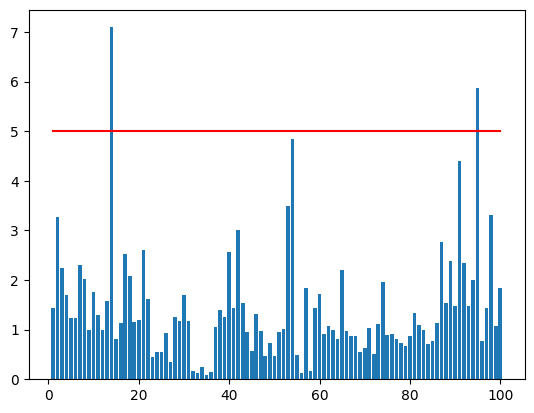

In [ ]:
# no_df = pd.DataFrame({'score':scores})

sm_list = pd.DataFrame(sm_list, columns = ['smape'])
sm_list.describe()

plt.bar(np.arange(len(sm_list))+1, sm_list['smape'])
plt.plot([1,100], [5, 5], color = 'red')

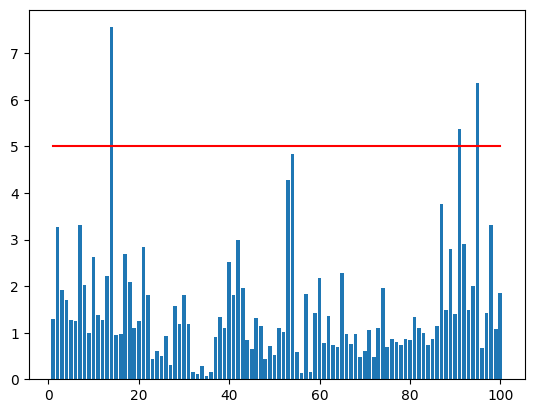

In [ ]:
# no_df = pd.DataFrame({'score':scores})
plt.bar(np.arange(len(sm_list))+1, sm_list['smape'])
plt.plot([1,100], [5, 5], color = 'red')

In [ ]:
#mode 2
sm_list = pd.DataFrame(sm_list, columns = ['smape'])
sm_list.describe()
#sm_list.to_csv('/gdrive/MyDrive/dacon/LGBM/sampe_0823_btscv-m2.csv')

,smape
count,100.000000
mean,1.730233
std,1.258835
min,0.052824
25%,1.054664
50%,1.460403
75%,2.190248
max,7.556552


In [ ]:
#sm_list = pd.DataFrame(sm_list, columns = ['smape'])
#sm_list = pd.read_csv('/gdrive/MyDrive/dacon/LGBM/sampe_0823_btscv.csv')
sm_list.describe()
#sm_list.to_csv('/gdrive/MyDrive/dacon/LGBM/sampe_0822_nl+huber.csv')

,smape
count,100.000000
mean,1.730233
std,1.258835
min,0.052824
25%,1.054664
50%,1.460403
75%,2.190248
max,7.556552


In [ ]:
#week X
sm_list.describe()

,0
count,100.000000
mean,2.217446
std,1.571386
min,0.108603
25%,1.129324
50%,1.942218
75%,2.842511
max,7.744415


In [ ]:
#area O
sm_list.describe()

,0
count,100.000000
mean,1.549922
std,1.196812
min,0.074467
25%,0.793333
50%,1.225710
75%,1.979669
max,7.492787


In [ ]:
#area X
sm_list.describe()

,0
count,100.000000
mean,1.498842
std,1.161438
min,0.072627
25%,0.709839
50%,1.219474
75%,1.929564
max,7.492787


# load hyperparameter csv

In [ ]:
lgbm_hyperparams = pd.read_csv('/gdrive/MyDrive/dacon/LGBM/params_0822_subsample.csv')
lgbm_hyperparams.head()

,learning_rate,n_estimators,num_leaves,boosting_type,colsample_bytree,subsample,max_depth,verbosity,force_col_wise
0,0.07,100,12,gbdt,0.9,0.3,4,-1,True
1,0.07,100,12,gbdt,0.7,0.3,8,-1,True
2,0.07,100,12,gbdt,0.9,0.3,4,-1,True
3,0.07,100,12,gbdt,0.7,0.3,8,-1,True
4,0.07,100,16,gbdt,0.9,0.3,6,-1,True


## weighted_mse

In [ ]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [ ]:
def mae_alpha(alpha = 1):
  def feval_func(preds, train_data):
    eval_result = mean_absolute_error(train_data,preds)
    return ('feval_func_name', eval_result, False)
  return feval_func

## n_estim

In [ ]:
#lgbm_hyperparams = lgbm_hyperparams.astype({'num_leaves':'int'})
#lgbm_hyperparams.to_csv('/gdrive/MyDrive/dacon/LGBM/params_0822_nl+huber+mdl.csv', index = False)
lgbm_hyperparams = pd.read_csv('/gdrive/MyDrive/dacon/LGBM/params_0824_stonly.csv')
lgbm_hyperparams.head()
#lgbm_hyperparams.drop('Unnamed: 0', axis = 1, inplace = True)

,learning_rate,n_estimators,colsample_bytree,max_depth,num_leaves,boosting_type,force_col_wise,verbosity
0,0.07,100,0.9,7,31,gbdt,True,-1.0
1,0.07,100,0.9,6,31,gbdt,True,-1.0
2,0.07,100,0.9,5,31,gbdt,True,-1.0
3,0.07,100,0.9,6,12,gbdt,True,-1.0
4,0.07,100,0.8,4,3,gbdt,True,-1.0


In [ ]:
scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list

n_estim_preds = pd.DataFrame()

for i in tqdm(range(100)):
    y = train.loc[train.num == i+1, 'power']
    x = train.loc[train.num == i+1, features]
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)

    lgbm = LGBMRegressor(seed = 0, n_estimators = 10000,
                         #n_estimators = lgbm_hyperparams.iloc[i,1]
                         learning_rate= lgbm_hyperparams.iloc[i,0],
                         num_leaves= lgbm_hyperparams.iloc[i,4], #num_leaves = 31,
                         #boosting_type= 'gbdt',
                         colsample_bytree= lgbm_hyperparams.iloc[i,2],
                         #subsample= lgbm_hyperparams.iloc[i,-1],
                         max_depth= lgbm_hyperparams.iloc[i, 3],
                         metric = 'mae')
                         #verbosity = -1, force_col_wise = True)

    #lgbm.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정

    lgbm.fit(x_train, y_train, eval_set=[(x_train, y_train),
                                            (x_valid, y_valid)],eval_metric = 'mae', early_stopping_rounds=300, verbose=False)
    y_pred = lgbm.predict(x_valid)
    #pred = pd.Series(y_pred)
    #print(pred)

    n_estim_preds = n_estim_preds.append(pd.DataFrame(y_pred).T)

    sm = SMAPE(y_valid, y_pred)
    scores.append(sm)
    best_it.append(lgbm.best_iteration_) ## 실제 best iteration은 이 값에 +1 해주어야 함.
    print("building {} || best iter : {} || smape : {}".format(i+1, lgbm.best_iteration_, sm))

  1%|          | 1/100 [00:00<00:31,  3.14it/s]

building 1 || best iter : 127 || smape : 2.4900681280001726


  3%|▎         | 3/100 [00:00<00:23,  4.13it/s]

building 2 || best iter : 76 || smape : 4.0975552652583405
building 3 || best iter : 22 || smape : 7.314798881664202


  4%|▍         | 4/100 [00:00<00:20,  4.70it/s]

building 4 || best iter : 39 || smape : 2.7301433622441094
building 5 || best iter : 113 || smape : 2.7197723927687765


  6%|▌         | 6/100 [00:01<00:14,  6.40it/s]

building 6 || best iter : 119 || smape : 1.7359871967918734


  8%|▊         | 8/100 [00:01<00:19,  4.79it/s]

building 7 || best iter : 120 || smape : 3.486695838621606
building 8 || best iter : 69 || smape : 2.3147682386921984


  9%|▉         | 9/100 [00:01<00:16,  5.37it/s]

building 9 || best iter : 63 || smape : 1.4988806323720631
building 10 || best iter : 163 || smape : 3.7355848443819673


 11%|█         | 11/100 [00:02<00:13,  6.46it/s]

building 11 || best iter : 61 || smape : 1.481478659291555


 13%|█▎        | 13/100 [00:02<00:15,  5.54it/s]

building 12 || best iter : 170 || smape : 1.913455375431393
building 13 || best iter : 92 || smape : 2.4040861919796908


 14%|█▍        | 14/100 [00:02<00:17,  5.02it/s]

building 14 || best iter : 16 || smape : 8.268023437764334


 16%|█▌        | 16/100 [00:03<00:15,  5.28it/s]

building 15 || best iter : 52 || smape : 1.3193023534588635
building 16 || best iter : 29 || smape : 2.9888085465047722


 18%|█▊        | 18/100 [00:03<00:13,  6.19it/s]

building 17 || best iter : 66 || smape : 2.756694801918457
building 18 || best iter : 102 || smape : 3.4123683604856745


 19%|█▉        | 19/100 [00:09<02:24,  1.79s/it]

building 19 || best iter : 245 || smape : 3.76955607763394


 21%|██        | 21/100 [00:09<01:18,  1.00it/s]

building 20 || best iter : 135 || smape : 1.7567706385538329
building 21 || best iter : 166 || smape : 3.006935101901533


 22%|██▏       | 22/100 [00:10<01:05,  1.18it/s]

building 22 || best iter : 69 || smape : 1.810301738076799


 23%|██▎       | 23/100 [00:10<00:54,  1.42it/s]

building 23 || best iter : 112 || smape : 0.6865987536427529


 24%|██▍       | 24/100 [00:16<02:52,  2.27s/it]

building 24 || best iter : 1273 || smape : 1.0276053041685567


 25%|██▌       | 25/100 [00:16<02:04,  1.66s/it]

building 25 || best iter : 144 || smape : 0.9274443864533513
building 26 || best iter : 64 || smape : 0.8960945105800967


 27%|██▋       | 27/100 [00:17<01:05,  1.11it/s]

building 27 || best iter : 105 || smape : 0.7736767551714665


 28%|██▊       | 28/100 [00:17<00:50,  1.43it/s]

building 28 || best iter : 164 || smape : 2.325187526061138


 30%|███       | 30/100 [00:17<00:32,  2.17it/s]

building 29 || best iter : 255 || smape : 1.5526397207733482
building 30 || best iter : 49 || smape : 3.46971125448838


 31%|███       | 31/100 [00:18<00:29,  2.33it/s]

building 31 || best iter : 156 || smape : 2.4480102633644902


 32%|███▏      | 32/100 [00:18<00:25,  2.63it/s]

building 32 || best iter : 139 || smape : 0.18794000012180334


 33%|███▎      | 33/100 [00:21<01:18,  1.17s/it]

building 33 || best iter : 131 || smape : 0.12824790280279813


 34%|███▍      | 34/100 [00:22<01:20,  1.22s/it]

building 34 || best iter : 56 || smape : 0.29203340725289506


 36%|███▌      | 36/100 [00:23<00:45,  1.41it/s]

building 35 || best iter : 552 || smape : 0.19420808767739503
building 36 || best iter : 143 || smape : 0.1664198038961616


 38%|███▊      | 38/100 [00:23<00:25,  2.44it/s]

building 37 || best iter : 103 || smape : 1.8919180556114068
building 38 || best iter : 68 || smape : 2.397496068826178


 39%|███▉      | 39/100 [00:23<00:20,  2.95it/s]

building 39 || best iter : 63 || smape : 2.675884123952725


 41%|████      | 41/100 [00:23<00:15,  3.92it/s]

building 40 || best iter : 35 || smape : 5.2453833982761
building 41 || best iter : 93 || smape : 2.2125973094096736


 43%|████▎     | 43/100 [00:24<00:12,  4.51it/s]

building 42 || best iter : 84 || smape : 5.4244932016595255
building 43 || best iter : 105 || smape : 2.5702702952487506


 44%|████▍     | 44/100 [00:24<00:12,  4.31it/s]

building 44 || best iter : 57 || smape : 2.135122386580937


 46%|████▌     | 46/100 [00:24<00:10,  5.00it/s]

building 45 || best iter : 63 || smape : 0.9694326130874055
building 46 || best iter : 145 || smape : 2.0548152596529565


 47%|████▋     | 47/100 [00:25<00:11,  4.60it/s]

building 47 || best iter : 83 || smape : 1.9669462990992121


 49%|████▉     | 49/100 [00:25<00:10,  4.68it/s]

building 48 || best iter : 115 || smape : 0.8323113623045634
building 49 || best iter : 98 || smape : 0.8335722366799645


 50%|█████     | 50/100 [00:25<00:10,  4.95it/s]

building 50 || best iter : 137 || smape : 0.9701823960931102


 52%|█████▏    | 52/100 [00:26<00:09,  4.93it/s]

building 51 || best iter : 188 || smape : 1.6720156019020986
building 52 || best iter : 69 || smape : 1.5317770876628924


 53%|█████▎    | 53/100 [00:26<00:08,  5.58it/s]

building 53 || best iter : 212 || smape : 4.515281960605133


 54%|█████▍    | 54/100 [00:26<00:09,  5.02it/s]

building 54 || best iter : 26 || smape : 12.736978113355155


 55%|█████▌    | 55/100 [00:26<00:11,  4.03it/s]

building 55 || best iter : 156 || smape : 0.7284303771984633


 57%|█████▋    | 57/100 [00:27<00:10,  4.18it/s]

building 56 || best iter : 466 || smape : 0.2676846639311326
building 57 || best iter : 83 || smape : 2.0178682014607605


 58%|█████▊    | 58/100 [00:27<00:09,  4.38it/s]

building 58 || best iter : 119 || smape : 0.17730847235521335


 60%|██████    | 60/100 [00:28<00:08,  4.48it/s]

building 59 || best iter : 86 || smape : 2.2023200072516653
building 60 || best iter : 56 || smape : 2.460014003637914


 62%|██████▏   | 62/100 [00:28<00:07,  5.28it/s]

building 61 || best iter : 91 || smape : 1.6622712689696724
building 62 || best iter : 128 || smape : 2.0992495115630816


 64%|██████▍   | 64/100 [00:28<00:07,  5.11it/s]

building 63 || best iter : 59 || smape : 2.251641800823629
building 64 || best iter : 83 || smape : 1.7656802117675947


 66%|██████▌   | 66/100 [00:29<00:06,  4.89it/s]

building 65 || best iter : 40 || smape : 4.55886448022973
building 66 || best iter : 142 || smape : 1.529038847798156


 67%|██████▋   | 67/100 [00:29<00:09,  3.49it/s]

building 67 || best iter : 403 || smape : 3.3721622442433006


 68%|██████▊   | 68/100 [00:30<00:10,  3.17it/s]

building 68 || best iter : 576 || smape : 1.6453317465855637


 69%|██████▉   | 69/100 [00:30<00:09,  3.36it/s]

building 69 || best iter : 64 || smape : 1.2323710967713761


 71%|███████   | 71/100 [00:30<00:07,  3.87it/s]

building 70 || best iter : 144 || smape : 1.0700706003015457
building 71 || best iter : 48 || smape : 1.5002732203842204


 73%|███████▎  | 73/100 [00:31<00:04,  5.44it/s]

building 72 || best iter : 63 || smape : 2.4407825094430615
building 73 || best iter : 280 || smape : 1.3814042913656541


 74%|███████▍  | 74/100 [00:31<00:04,  5.52it/s]

building 74 || best iter : 102 || smape : 2.329335860693047


 75%|███████▌  | 75/100 [00:31<00:05,  4.66it/s]

building 75 || best iter : 53 || smape : 1.616258322763129


 77%|███████▋  | 77/100 [00:32<00:05,  4.55it/s]

building 76 || best iter : 27 || smape : 1.9242414189401074
building 77 || best iter : 196 || smape : 1.1707095694939893


 78%|███████▊  | 78/100 [00:32<00:04,  4.71it/s]

building 78 || best iter : 71 || smape : 1.4736092486308319
building 79 || best iter : 74 || smape : 1.2205733111711914


 80%|████████  | 80/100 [00:32<00:04,  4.78it/s]

building 80 || best iter : 120 || smape : 1.5706982767097022


 81%|████████  | 81/100 [00:36<00:21,  1.16s/it]

building 81 || best iter : 257 || smape : 1.5451018220264168


 82%|████████▏ | 82/100 [00:36<00:16,  1.10it/s]

building 82 || best iter : 86 || smape : 1.9377245324441807


 83%|████████▎ | 83/100 [00:37<00:12,  1.38it/s]

building 83 || best iter : 64 || smape : 1.1432786923697555


 85%|████████▌ | 85/100 [00:37<00:07,  2.09it/s]

building 84 || best iter : 58 || smape : 1.3036827483048665
building 85 || best iter : 325 || smape : 1.462634337377286


 86%|████████▌ | 86/100 [00:37<00:05,  2.65it/s]

building 86 || best iter : 236 || smape : 2.8434746824685626


 89%|████████▉ | 89/100 [00:38<00:02,  4.03it/s]

building 87 || best iter : 282 || smape : 4.37369455575577
building 88 || best iter : 84 || smape : 3.2619574855875486
building 89 || best iter : 81 || smape : 3.721307200141956


 91%|█████████ | 91/100 [00:38<00:01,  5.20it/s]

building 90 || best iter : 57 || smape : 4.052397569682572
building 91 || best iter : 104 || smape : 5.652820592088141


 93%|█████████▎| 93/100 [00:38<00:01,  6.23it/s]

building 92 || best iter : 123 || smape : 2.9887659499247645
building 93 || best iter : 103 || smape : 2.917190118309577


 95%|█████████▌| 95/100 [00:39<00:00,  6.42it/s]

building 94 || best iter : 136 || smape : 2.563546375694133
building 95 || best iter : 125 || smape : 7.624206064068044
building 96 || best iter : 108 || smape : 1.482272916242259


 97%|█████████▋| 97/100 [00:39<00:00,  5.78it/s]

building 97 || best iter : 92 || smape : 2.1417046845021197


 98%|█████████▊| 98/100 [00:39<00:00,  4.80it/s]

building 98 || best iter : 88 || smape : 5.943728748956404


 99%|█████████▉| 99/100 [00:40<00:00,  4.54it/s]

building 99 || best iter : 93 || smape : 1.4779285233987332


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]

building 100 || best iter : 85 || smape : 2.6786851129152116


In [ ]:
lgbm_hyperparams = lgbm_hyperparams.join(pd.DataFrame(best_it, columns = ['best_iter']))
lgbm_hyperparams.to_csv('/gdrive/MyDrive/dacon/LGBM/params_0824_stonly.csv')

In [ ]:
#w / addtr
sm_list = pd.DataFrame(scores, columns = ['smape'])
sm_list.describe()
#sm_list.to_csv('/gdrive/MyDrive/dacon/LGBM/sampe_0823_btscv.csv')

,smape
count,100.000000
mean,2.415086
std,1.874755
min,0.128248
25%,1.442327
50%,1.992407
75%,2.861904
max,12.736978


In [ ]:
ch = pd.read_csv('/gdrive/MyDrive/dacon/LGBM/sampe_0822_nl+huber+addtr.csv', index_col = 0)
ch.describe()

,smape
count,100.000000
mean,2.411826
std,1.840088
min,0.135405
25%,1.411122
50%,1.954487
75%,2.798156
max,12.310062


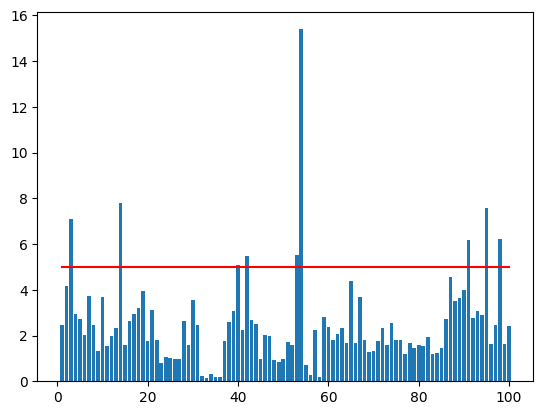

In [ ]:
#no_df = pd.DataFrame({'score':scores})
plt.bar(np.arange(len(sm_list))+1, sm_list['smape'])
plt.plot([1,100], [5, 5], color = 'red')

In [ ]:
ch = pd.read_csv('/gdrive/MyDrive/dacon/LGBM/sampe_0822_nl.csv', index_col = 0)
ch.describe()

,smape
count,100.000000
mean,2.428566
std,1.843068
min,0.139720
25%,1.418276
50%,1.988841
75%,2.850731
max,12.310062


In [ ]:
# w/o st + mean / std
sm_list = pd.DataFrame(scores, columns = ['smape'])
sm_list.describe()

,smape
count,100.000000
mean,2.428718
std,1.886864
min,0.127223
25%,1.432310
50%,2.007145
75%,2.799074
max,13.213093


In [ ]:
# st only
sm_list = pd.DataFrame(scores, columns = ['smape'])
sm_list.describe()
#sm_list.to_csv('/gdrive/MyDrive/dacon/LGBM/sampe_0824_stonly.csv')

,smape
count,100.000000
mean,2.415086
std,1.874755
min,0.128248
25%,1.442327
50%,1.992407
75%,2.861904
max,12.736978


# check - 실제 마지막 일주일 데이터 위에 예측 값 그려보기

In [ ]:
lgbm_hyperparams

,learning_rate,n_estimators,min_child_samples,boosting_type,colsample_bytree,subsample,max_depth,verbosity,force_col_wise,num_leaves,best_iter
0,0.07,100,50,gbdt,0.9,1.0,8,-1,True,153,80
1,0.07,100,50,gbdt,0.9,1.0,8,-1,True,153,48
2,0.07,100,50,gbdt,0.9,1.0,5,-1,True,10,25
3,0.07,100,50,gbdt,0.8,1.0,6,-1,True,38,40
4,0.07,100,50,gbdt,0.9,1.0,3,-1,True,3,127
...,...,...,...,...,...,...,...,...,...,...,...
95,0.07,100,50,gbdt,0.7,1.0,3,-1,True,2,99
96,0.07,100,50,gbdt,0.7,1.0,4,-1,True,7,92
97,0.07,100,50,gbdt,0.7,1.0,5,-1,True,6,167
98,0.07,100,50,gbdt,0.9,1.0,5,-1,True,10,118


In [ ]:
n_estim_preds = pd.DataFrame()

for i in tqdm(range(100)):
    y = train.loc[train.num == i+1, 'power']
    x = train.loc[train.num == i+1, features]
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)

    lgbm = LGBMRegressor(seed = 0, n_estimators = lgbm_hyperparams.iloc[i,1],
                        learning_rate= lgbm_hyperparams.iloc[i,0],
                        num_leaves= lgbm_hyperparams.iloc[i,-2], boosting_type= 'gbdt',
                        colsample_bytree= lgbm_hyperparams.iloc[i,4],
                        subsample= lgbm_hyperparams.iloc[i,5],
                        max_depth= lgbm_hyperparams.iloc[i, 6],
                        metric = 'mae',
                        verbosity = -1, force_col_wise = True)

    #lgbm.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정

    lgbm.fit(x_train, y_train)
    y_pred = lgbm.predict(x_valid)

    n_estim_preds = n_estim_preds.append(pd.DataFrame(y_pred).T)

n_estim_preds = np.transpose(n_estim_preds)

100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


In [ ]:
for i in range(100):
    power = train[train.num == i+1].power.reset_index(drop = True)
    preds = n_estim_preds.iloc[:,i].reset_index(drop = True)
    preds.index = np.arange(2040-167, 2041)

    plot_series(power, preds, markers = [',', ','])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(100):
    power = train[train.num == i+1].power.reset_index(drop = True)
    preds = n_estim_preds.iloc[:,i].reset_index(drop = True)
    preds.index = np.arange(2040-167, 2041)

    plot_series(power, preds, markers = [',', ','])

Output hidden; open in https://colab.research.google.com to view.

# alpha tuning

In [ ]:
alpha_list = []
smape_list = []
for i in tqdm(range(100)):
    y = train.loc[train.num == i+1, 'power']
    x = train.loc[train.num == i+1, features]
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    lgbm = LGBMRegressor(seed = 0, n_estimators = best_it[i],
                        learning_rate= lgbm_hyperparams.iloc[i,0],
                        num_leaves= lgbm_hyperparams.iloc[i,2], boosting_type= 'gbdt',
                        colsample_bytree= lgbm_hyperparams.iloc[i,4],
                        subsample= lgbm_hyperparams.iloc[i,5],
                        max_depth= lgbm_hyperparams.iloc[i, 6],
                        #eval_metric = 'rmse',
                        verbosity = -1, force_col_wise = True)

    lgbm.fit(x_train, y_train)
    pred0 = lgbm.predict(x_test)
    best_alpha = 0
    score0 = SMAPE(y_test,pred0)

    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        lgbm = LGBMRegressor(seed = 0, n_estimators = best_it[i],
                        learning_rate= lgbm_hyperparams.iloc[i,0],
                        num_leaves= lgbm_hyperparams.iloc[i,2], boosting_type= 'gbdt',
                        colsample_bytree= lgbm_hyperparams.iloc[i,4],
                        subsample= lgbm_hyperparams.iloc[i,5],
                        max_depth= lgbm_hyperparams.iloc[i, 6],
                        #eval_metric = 'rmse',
                        verbosity = -1, force_col_wise = True)
        lgbm.set_params(**{'objective' : weighted_mse(j)})

        lgbm.fit(x_train, y_train)
        pred1 = lgbm.predict(x_test)
        score1 = SMAPE(y_test, pred1)
        if score1 < score0:
            best_alpha = j
            score0 = score1

    alpha_list.append(best_alpha)
    smape_list.append(score0)
    print("building {} || best score : {} || alpha : {}".format(i+1, score0, best_alpha))

  2%|▏         | 2/100 [00:00<00:18,  5.19it/s]

building 1 || best score : 2.607962935046093 || alpha : 1
building 2 || best score : 4.30895663612631 || alpha : 0


  4%|▍         | 4/100 [00:00<00:20,  4.75it/s]

building 3 || best score : 4.643680665132531 || alpha : 25
building 4 || best score : 1.84502465585574 || alpha : 3


  5%|▌         | 5/100 [00:15<08:38,  5.45s/it]

building 5 || best score : 2.6377562178121234 || alpha : 75


  6%|▌         | 6/100 [00:15<05:50,  3.73s/it]

building 6 || best score : 1.7607833736693328 || alpha : 100


  7%|▋         | 7/100 [00:21<06:29,  4.19s/it]

building 7 || best score : 4.005749833918502 || alpha : 0


  8%|▊         | 8/100 [00:22<04:53,  3.19s/it]

building 8 || best score : 2.337123767920583 || alpha : 75


 10%|█         | 10/100 [00:22<02:27,  1.64s/it]

building 9 || best score : 1.5084574279056115 || alpha : 0
building 10 || best score : 3.334832519989206 || alpha : 7


 11%|█         | 11/100 [00:22<01:46,  1.19s/it]

building 11 || best score : 1.500994727145039 || alpha : 50


 12%|█▏        | 12/100 [00:28<03:35,  2.45s/it]

building 12 || best score : 1.8536319215854147 || alpha : 0


 14%|█▍        | 14/100 [00:28<01:51,  1.30s/it]

building 13 || best score : 2.322016490426622 || alpha : 0
building 14 || best score : 7.769937475452079 || alpha : 75


 15%|█▌        | 15/100 [00:29<01:27,  1.03s/it]

building 15 || best score : 1.2437847219436717 || alpha : 75


 16%|█▌        | 16/100 [00:29<01:06,  1.26it/s]

building 16 || best score : 2.1027178570488747 || alpha : 3


 17%|█▋        | 17/100 [00:29<00:57,  1.44it/s]

building 17 || best score : 2.6187235841618657 || alpha : 7


 18%|█▊        | 18/100 [00:29<00:45,  1.78it/s]

building 18 || best score : 3.1030085180018907 || alpha : 0


 19%|█▉        | 19/100 [00:30<00:43,  1.84it/s]

building 19 || best score : 3.7322083464215225 || alpha : 3


 21%|██        | 21/100 [00:30<00:29,  2.70it/s]

building 20 || best score : 2.0664441363175134 || alpha : 0
building 21 || best score : 3.1149091902293846 || alpha : 0


 22%|██▏       | 22/100 [00:31<00:25,  3.10it/s]

building 22 || best score : 1.8562515446521222 || alpha : 3


 23%|██▎       | 23/100 [00:31<00:24,  3.12it/s]

building 23 || best score : 0.7247852838307036 || alpha : 0


 24%|██▍       | 24/100 [00:37<02:39,  2.09s/it]

building 24 || best score : 0.9285141027434952 || alpha : 25


 25%|██▌       | 25/100 [00:38<02:00,  1.60s/it]

building 25 || best score : 1.0185255578230539 || alpha : 0


 26%|██▌       | 26/100 [00:38<01:28,  1.19s/it]

building 26 || best score : 1.0431805594550536 || alpha : 7


 28%|██▊       | 28/100 [00:38<00:48,  1.47it/s]

building 27 || best score : 0.8276325036772089 || alpha : 25
building 28 || best score : 1.9022770874291237 || alpha : 5


 29%|██▉       | 29/100 [00:38<00:37,  1.88it/s]

building 29 || best score : 1.669132671322432 || alpha : 1


 31%|███       | 31/100 [00:40<00:48,  1.43it/s]

building 30 || best score : 3.246373355380468 || alpha : 50
building 31 || best score : 2.0366406336321132 || alpha : 50


 32%|███▏      | 32/100 [00:41<00:54,  1.25it/s]

building 32 || best score : 0.18094421608616182 || alpha : 100


 33%|███▎      | 33/100 [00:42<00:46,  1.45it/s]

building 33 || best score : 0.12976739593195913 || alpha : 5


 34%|███▍      | 34/100 [00:42<00:40,  1.63it/s]

building 34 || best score : 0.3132569541562063 || alpha : 25


 35%|███▌      | 35/100 [00:48<02:28,  2.28s/it]

building 35 || best score : 0.16985814747487107 || alpha : 50


 36%|███▌      | 36/100 [00:49<01:48,  1.70s/it]

building 36 || best score : 0.1764192543890628 || alpha : 100


 37%|███▋      | 37/100 [00:49<01:20,  1.28s/it]

building 37 || best score : 1.8460123107114979 || alpha : 25


 38%|███▊      | 38/100 [00:49<00:59,  1.03it/s]

building 38 || best score : 2.340148993064605 || alpha : 3


 39%|███▉      | 39/100 [00:50<00:47,  1.28it/s]

building 39 || best score : 1.908689807922501 || alpha : 25


 40%|████      | 40/100 [00:50<00:36,  1.62it/s]

building 40 || best score : 4.7159138581532165 || alpha : 0


 41%|████      | 41/100 [00:50<00:31,  1.88it/s]

building 41 || best score : 1.9016978111538938 || alpha : 7


 42%|████▏     | 42/100 [00:51<00:25,  2.30it/s]

building 42 || best score : 8.98399426654829 || alpha : 1


 44%|████▍     | 44/100 [00:55<01:02,  1.11s/it]

building 43 || best score : 2.5695720292696027 || alpha : 0
building 44 || best score : 1.8909327984746742 || alpha : 1


 46%|████▌     | 46/100 [00:55<00:37,  1.46it/s]

building 45 || best score : 0.9931251719889905 || alpha : 25
building 46 || best score : 2.1183551698013505 || alpha : 0


 47%|████▋     | 47/100 [00:56<00:32,  1.62it/s]

building 47 || best score : 1.9562051245541203 || alpha : 0


 48%|████▊     | 48/100 [00:56<00:26,  1.99it/s]

building 48 || best score : 0.9618820553273809 || alpha : 0


 50%|█████     | 50/100 [00:56<00:17,  2.82it/s]

building 49 || best score : 0.9029209143243736 || alpha : 0
building 50 || best score : 0.8273216904230261 || alpha : 50


 51%|█████     | 51/100 [01:00<01:06,  1.36s/it]

building 51 || best score : 1.7284210925524357 || alpha : 7


 53%|█████▎    | 53/100 [01:01<00:38,  1.23it/s]

building 52 || best score : 1.3993211241966645 || alpha : 5
building 53 || best score : 4.819303440409891 || alpha : 1


 54%|█████▍    | 54/100 [01:01<00:30,  1.51it/s]

building 54 || best score : 8.60609490080423 || alpha : 50


 55%|█████▌    | 55/100 [01:01<00:25,  1.78it/s]

building 55 || best score : 0.7111615797819352 || alpha : 25


 56%|█████▌    | 56/100 [01:02<00:20,  2.10it/s]

building 56 || best score : 0.3191693619939039 || alpha : 5


 57%|█████▋    | 57/100 [01:02<00:17,  2.51it/s]

building 57 || best score : 2.217425288740141 || alpha : 1


 58%|█████▊    | 58/100 [01:02<00:17,  2.36it/s]

building 58 || best score : 0.1778462352752836 || alpha : 0


 59%|█████▉    | 59/100 [01:03<00:17,  2.40it/s]

building 59 || best score : 2.0309410146166624 || alpha : 1


 61%|██████    | 61/100 [01:03<00:11,  3.28it/s]

building 60 || best score : 2.5978675598452288 || alpha : 0
building 61 || best score : 1.9516771763013554 || alpha : 10


 62%|██████▏   | 62/100 [01:03<00:10,  3.56it/s]

building 62 || best score : 2.0584911745690913 || alpha : 10


 64%|██████▍   | 64/100 [01:04<00:08,  4.20it/s]

building 63 || best score : 2.240475304723594 || alpha : 0
building 64 || best score : 1.9375687614972388 || alpha : 7


 65%|██████▌   | 65/100 [01:04<00:08,  4.35it/s]

building 65 || best score : 4.355305614234948 || alpha : 1


 67%|██████▋   | 67/100 [01:04<00:06,  4.72it/s]

building 66 || best score : 1.5503887938679664 || alpha : 0
building 67 || best score : 2.2813955968133506 || alpha : 5


 68%|██████▊   | 68/100 [01:05<00:07,  4.21it/s]

building 68 || best score : 1.770185484792404 || alpha : 1


 69%|██████▉   | 69/100 [01:05<00:07,  4.12it/s]

building 69 || best score : 1.318919231918615 || alpha : 1


 70%|███████   | 70/100 [01:05<00:07,  3.89it/s]

building 70 || best score : 1.0790774217684822 || alpha : 75


 71%|███████   | 71/100 [01:06<00:09,  3.20it/s]

building 71 || best score : 1.6204701381301325 || alpha : 0


 72%|███████▏  | 72/100 [01:07<00:18,  1.55it/s]

building 72 || best score : 2.049720129084796 || alpha : 100


 73%|███████▎  | 73/100 [01:07<00:14,  1.86it/s]

building 73 || best score : 1.369223755365691 || alpha : 3


 74%|███████▍  | 74/100 [01:08<00:12,  2.10it/s]

building 74 || best score : 2.284500294572317 || alpha : 25


 75%|███████▌  | 75/100 [01:08<00:10,  2.42it/s]

building 75 || best score : 1.6989954576280792 || alpha : 25


 76%|███████▌  | 76/100 [01:08<00:08,  2.75it/s]

building 76 || best score : 2.1280521141921067 || alpha : 0


 77%|███████▋  | 77/100 [01:09<00:07,  2.97it/s]

building 77 || best score : 1.2125966573559088 || alpha : 5


 78%|███████▊  | 78/100 [01:11<00:23,  1.08s/it]

building 78 || best score : 1.5963567278139925 || alpha : 0


 79%|███████▉  | 79/100 [01:12<00:18,  1.16it/s]

building 79 || best score : 1.034314556281469 || alpha : 75


 80%|████████  | 80/100 [01:12<00:13,  1.43it/s]

building 80 || best score : 1.4221922104907434 || alpha : 75


 81%|████████  | 81/100 [01:12<00:10,  1.74it/s]

building 81 || best score : 1.4942412045664364 || alpha : 1


 82%|████████▏ | 82/100 [01:13<00:09,  1.85it/s]

building 82 || best score : 1.8393816978457327 || alpha : 3


 83%|████████▎ | 83/100 [01:13<00:08,  1.91it/s]

building 83 || best score : 1.1035148038467997 || alpha : 0


 84%|████████▍ | 84/100 [01:14<00:07,  2.07it/s]

building 84 || best score : 1.1376095871441236 || alpha : 100


 85%|████████▌ | 85/100 [01:16<00:15,  1.02s/it]

building 85 || best score : 1.542936828479026 || alpha : 50


 86%|████████▌ | 86/100 [01:16<00:10,  1.29it/s]

building 86 || best score : 2.1590669959002464 || alpha : 7


 87%|████████▋ | 87/100 [01:16<00:08,  1.59it/s]

building 87 || best score : 3.8288958621485465 || alpha : 50


 88%|████████▊ | 88/100 [01:17<00:06,  1.88it/s]

building 88 || best score : 2.2314728392061127 || alpha : 50


 89%|████████▉ | 89/100 [01:17<00:04,  2.27it/s]

building 89 || best score : 2.365546863867297 || alpha : 25


 91%|█████████ | 91/100 [01:17<00:03,  2.91it/s]

building 90 || best score : 2.4728626856649254 || alpha : 75
building 91 || best score : 6.054154351035895 || alpha : 3


 93%|█████████▎| 93/100 [01:18<00:02,  3.48it/s]

building 92 || best score : 2.51356052664339 || alpha : 100
building 93 || best score : 3.015605696442472 || alpha : 0


 95%|█████████▌| 95/100 [01:18<00:01,  4.16it/s]

building 94 || best score : 2.9164017364935133 || alpha : 0
building 95 || best score : 6.724238883341623 || alpha : 1


 96%|█████████▌| 96/100 [01:19<00:00,  4.37it/s]

building 96 || best score : 1.463067301662847 || alpha : 1


 98%|█████████▊| 98/100 [01:19<00:00,  4.45it/s]

building 97 || best score : 2.392778123073806 || alpha : 100
building 98 || best score : 6.0240546347877375 || alpha : 1


 99%|█████████▉| 99/100 [01:19<00:00,  3.92it/s]

building 99 || best score : 1.4688723285734384 || alpha : 1


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]

building 100 || best score : 2.326413001488796 || alpha : 0


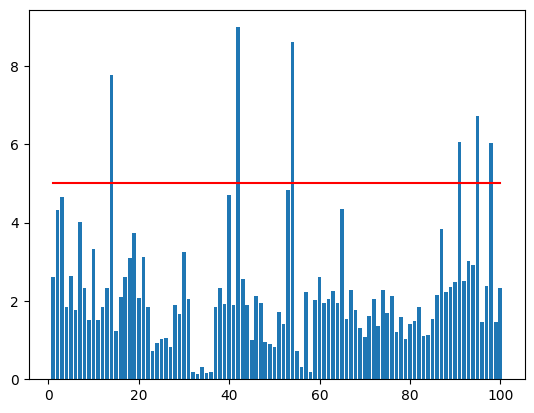

In [ ]:
no_df = pd.DataFrame({'score':smape_list})
plt.bar(np.arange(len(no_df))+1, no_df['score'])
plt.plot([1,100], [5, 5], color = 'red')

## comp

In [ ]:
no_df.describe()

,score
count,100.000000
mean,2.272012
std,1.655805
min,0.129767
25%,1.391797
50%,1.923129
75%,2.527563
max,8.983994


In [ ]:
#wm_df = pd.DataFrame({'wm_score':smape_list})
#mae_df = pd.DataFrame({'mae_score':scores})
#mae_noalpha = pd.DataFrame({'mae_noalpha_score':scores})
comp_df = mae_df.join(wm_df)
comp_df.join(mae_noalpha).describe()

,mae_score,wm_score,mae_noalpha_score
count,100.000000,100.000000,100.000000
mean,2.358098,2.268922,2.488873
std,1.811367,1.656363,2.151223
min,0.131778,0.129393,0.131778
25%,1.422101,1.399069,1.423590
50%,1.920869,1.901987,1.920869
75%,2.726764,2.514669,2.789974
max,12.376763,8.983994,13.881230


# test data

In [ ]:
lgbm_hyperparams.head()

,learning_rate,n_estimators,num_leaves,boosting_type,colsample_bytree,subsample,max_depth,verbosity,force_col_wise
0,0.09,100,12,gbdt,1.0,0.7,7,-1,True
1,0.09,100,8,gbdt,0.7,0.7,6,-1,True
2,0.05,100,16,gbdt,1.0,0.7,6,-1,True
3,0.10,100,8,gbdt,0.9,0.7,5,-1,True
4,0.05,100,6,gbdt,0.8,0.7,3,-1,True


In [ ]:
lgbm_hyperparams['alpha'] = alpha_list
lgbm_hyperparams['best_it_wm'] = best_it
lgbm_hyperparams.head()

,learning_rate,n_estimators,num_leaves,boosting_type,colsample_bytree,subsample,max_depth,verbosity,force_col_wise,alpha,best_it_wm
0,0.09,100,12,gbdt,1.0,0.7,7,-1,True,1,39
1,0.09,100,8,gbdt,0.7,0.7,6,-1,True,0,28
2,0.05,100,16,gbdt,1.0,0.7,6,-1,True,25,41
3,0.10,100,8,gbdt,0.9,0.7,5,-1,True,3,31
4,0.05,100,6,gbdt,0.8,0.7,3,-1,True,75,4820


In [ ]:
lgbm_hyperparams.to_csv('/gdrive/MyDrive/dacon/hyperparameter_lgbm_pds_wm_solar_final.csv', index=False)

In [ ]:
## best hyperparameters 불러오기
lgbm_params = pd.read_csv('/gdrive/MyDrive/dacon/hyperparameter_lgbm_pds_wm_solar_final.csv')

In [ ]:
lgbm_params.head()

,learning_rate,n_estimators,num_leaves,boosting_type,colsample_bytree,subsample,max_depth,verbosity,force_col_wise,alpha,best_it_wm
0,0.09,100,12,gbdt,1.0,0.7,7,-1,True,1,39
1,0.09,100,8,gbdt,0.7,0.7,6,-1,True,0,28
2,0.05,100,16,gbdt,1.0,0.7,6,-1,True,25,41
3,0.10,100,8,gbdt,0.9,0.7,5,-1,True,3,31
4,0.05,100,6,gbdt,0.8,0.7,3,-1,True,75,4820


# predict

## seed ensemble

In [ ]:
#test

In [ ]:
lgbm_hyperparams = pd.read_csv('/gdrive/MyDrive/dacon/LGBM/params_0824_stonly.csv', index_col = 0)
lgbm_hyperparams.head()

,learning_rate,n_estimators,colsample_bytree,max_depth,num_leaves,boosting_type,force_col_wise,verbosity,best_iter
0,0.07,100,0.9,7,31,gbdt,True,-1.0,127
1,0.07,100,0.9,6,31,gbdt,True,-1.0,76
2,0.07,100,0.9,5,31,gbdt,True,-1.0,22
3,0.07,100,0.9,6,12,gbdt,True,-1.0,39
4,0.07,100,0.8,4,3,gbdt,True,-1.0,113


In [ ]:
test = pd.read_csv('/gdrive/MyDrive/전력사용량 예측 공모전/data/processing/test_preprocessed_incsolar_month_senstemp_timev2.csv')
test.head()

,num,date_time,prec,wind,hum,temp,day,week,day_hour_mean,day_hour_std,holiday,sin_time,cos_time,THI,CDH,solar_flag,month,senstemp
0,1,2022-08-25 00:00:00,0.0,2.2,72,23.5,3,34,1627.80,446.984913,0,0.000000,1.000000,58.3456,-0.5,0,8,24.86
1,1,2022-08-25 01:00:00,0.0,0.9,72,23.0,3,34,1550.08,449.091398,0,0.258819,0.965926,57.4456,-1.5,0,8,24.36
2,1,2022-08-25 02:00:00,0.0,1.5,75,22.7,3,34,1431.12,415.453568,0,0.500000,0.866025,57.8725,-2.8,0,8,24.27
3,1,2022-08-25 03:00:00,0.0,1.3,78,22.1,3,34,1372.20,378.117772,0,0.707107,0.707107,57.9376,-4.7,0,8,23.87
4,1,2022-08-25 04:00:00,0.0,1.0,77,21.8,3,34,1381.72,360.348483,0,0.866025,0.500000,56.9961,-6.9,0,8,23.50


In [ ]:
preds = np.array([])
for i in tqdm(range(100)):

    pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame

    for seed in [0,1,2,3,4,5]: # 각 시드별 예측
        y_train = train.loc[train.num == i+1, 'power']
        x_train, x_test = train.loc[train.num == i+1, ].iloc[:, 3:], test.loc[test.num == i+1, ].iloc[:,2:]
        x_test = x_test[x_train.columns]

        lgbm = LGBMRegressor(seed = seed, n_estimators = lgbm_hyperparams.iloc[i, -1],
                        learning_rate= lgbm_hyperparams.iloc[i,0],
                        num_leaves= lgbm_hyperparams.iloc[i,4], #boosting_type= 'gbdt',
                        colsample_bytree= lgbm_hyperparams.iloc[i,2],
                        #n_estimators = lgbm_params.iloc[i,1],
                        max_depth= lgbm_hyperparams.iloc[i, 3],
                        metric = 'mae')
                        #verbosity = -1, force_col_wise = True)

        # if lgbm_params.iloc[i,10] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
        #     lgbm.set_params(**{'objective':weighted_mse(lgbm_params.iloc[i,6])})

        lgbm.fit(x_train, y_train)
        y_pred = lgbm.predict(x_test)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기

    pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    preds = np.append(preds, pred)

100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


In [ ]:
submission = pd.read_csv('/gdrive/MyDrive/dacon/data/sample_submission.csv')
submission['answer'] = preds
submission.to_csv('/gdrive/MyDrive/dacon/submission/lgbm_0824_addata.csv', index = False)